# House Prices | Kaggle Challenge
Advanced Regression Techniques

https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/overview


**Content**

1. Introduction
2. Preparation
3. Data
4. EDA
5. Transformations
6. Modeling
7. Results

*Author: Alexander Ulloa Opazo*

## 1. Introduction

*"Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence."*

In this notebook we aim to properly predict the price of houses given historical information. With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges us to predict the final price of each home.

Practice Skills: 
* Creative feature engineering 
* Advanced regression techniques

## 2. Preparation

### 2.1. Libraries

In [1]:
# Data transformation
import pandas as pd
import numpy as np
import math
import re 
import random

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import ptitprince as pt
import matplotlib as mpl
import shap
from wordcloud import WordCloud

# EDA
import sweetviz as sv

# Datetime
import pytz
import time
from datetime import datetime,timedelta, date

# Machine Learning
import optuna
import xgboost as xgb
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor,Pool
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_squared_log_error
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split , GridSearchCV, RepeatedStratifiedKFold, cross_validate, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler

# Warnings
import warnings
warnings.filterwarnings('ignore')

### 2.2. Paths

In [2]:
# Path
paths = dict()
paths["main"] = "C:/Users/ARULLOAO/OneDrive - Asociación Chilena de Seguridad/Desktop/Modulo 8/HW/"
paths["data"] = paths["main"] + "data/"

print(f'Main: {paths["main"]}')
print(f'Data: {paths["data"]}')

Main: C:/Users/ARULLOAO/OneDrive - Asociación Chilena de Seguridad/Desktop/Modulo 8/HW/
Data: C:/Users/ARULLOAO/OneDrive - Asociación Chilena de Seguridad/Desktop/Modulo 8/HW/data/


### 2.3. Dates

In [3]:
# Dates
today = date.today()
today_file = datetime.now(pytz.timezone('America/Santiago')).strftime('%Y%m%d')
today_path = datetime.now(pytz.timezone('America/Santiago')).strftime('%Y/%m/%d')

print(f'Today: {today}')
print(f'Today as file: {today_file}')
print(f'Today as folder: {today_path}')

Today: 2022-12-21
Today as file: 20221221
Today as folder: 2022/12/21


### 2.4. Functions

In [4]:
# EDA

def func_get_nulls(df):
    '''
    Function to know the amount of nulls per variable and its proportion from a dataframe    
    '''
    df_nulls = pd.DataFrame(df.isnull().sum(), columns=['nulls_count']).reset_index().rename(columns={'index':'variable'})
    df_nulls['nulls_proportion(%)'] = round((df_nulls['nulls_count']/df.shape[0])*100,3)
    df_nulls_porc = df_nulls[df_nulls['nulls_count']>0].sort_values(by='nulls_count', ascending=False)
    print(f'Number of variables with nulls: {df_nulls_porc.shape[0]}')
    
    return df_nulls_porc

def func_get_unique_values(df, unique_umbral = 10):
    '''Function to know the amount of unique valors per variable and its proportion from a dataframe'''
    df_unique = pd.DataFrame(df.nunique(), columns=['unique_count']).reset_index().rename(columns={'index':'variable'})
    df_unique['unique_proportion(%)'] = round((df_unique['unique_count']/df.shape[0])*100,3)
    df_unique_porc = df_unique[df_unique['unique_count']>= unique_umbral].sort_values(by='unique_count', ascending=True)

    print(f'Number of variables with unique values >= {unique_umbral} : {df_unique_porc.shape[0]} out of {df_unique.shape[0]}')
    
    return df_unique_porc

def func_basic_eda(df):
    '''Function to obtain basic exploratory information from all the variables in a dataframe'''
    l=list()
    for var in df.columns:
        d=dict()
        d['variable']=var
        d['unique']=len(df[var].unique())
        d['dtype']=df[var].dtype
        d['nulls']=len(df[df[var].isna()])
        if d['dtype']!='object':
            d['median']=df[var].median()
            d['mean']=df[var].mean()
            d['std']=df[var].std()
            d['max']=df[var].max()
            d['min']=df[var].min()
            d['zeros']=len(df[df[var]==0])/len(df)
            d['mode']=df[var].mode()[0]
        
        else:
            d['mode']=df[var].mode()[0]

        d['example']=','.join([str(x) for x in random.choices(df[var].unique().tolist(), k=5)])
        l.append(d)
    
    df_eda=pd.DataFrame(l)
    df_eda['nulls_proportion']  = df_eda['nulls']/df.shape[0]
    df_eda['unique_proportion'] = df_eda['unique']/df.shape[0]

    df_eda = df_eda[['variable','dtype','unique','unique_proportion','nulls','nulls_proportion','median','mean','std','max','min','zeros','mode','example']]
    return df_eda

In [5]:
# Plots

def func_box_plot(df,var, pal='Blues', color='royalblue', size=(8, 4), xticks=None):
  '''
  Function which returns a box plot and density of a numeric variable
  Input 
      -df: Data frame
      -var: variable to analyze
  Output
      - Boxplot and density chart
  '''
  f, ax = plt.subplots(figsize=size)

  # Variables  
  dx = df[var]
  dy = None
  title = f'Distribution of the variable {var}'

  ax = pt.half_violinplot( x = dx, y = dy, data = df, width = .6, color=color, scale = "area", inner = None)
  ax = sns.stripplot( x = dx, y = dy, data = df, jitter=True, palette = pal, edgecolor = "white", size = 0.3 , zorder = 0)
  ax = sns.boxplot(x=dx, y=dy,data = df, width = .15, color = "black", zorder = 10, showcaps = True, fliersize=3,
                 boxprops = {'facecolor':'none', "zorder":10}, showfliers=True, whiskerprops = {'linewidth':2, "zorder":10},saturation = 1)

  plt.title(title, fontsize=11)
  plt.xticks(ticks=xticks, rotation=0)
  plt.grid(color='gray', linestyle='--', linewidth=0.5, axis='x', alpha=0.3)
  sns.set_style("whitegrid")

  plt.show()


def func_bar_plot(df, var, color='royalblue', size=(8, 4), bool_grouped=False, df_grouped=None, bool_horizontal=True, rotation=0):
  '''
  Function which return a barplot from a variable of the dataframe  
  Input 
      -df: Data frame
      -var: variable to analyze
      -bool_grouped: Bool para indicar si Dataframe ya está agrupado
      -df_grouped: If grouped_bool==True then a grouped dataframe is needed (cols: variable | count)
      -bool_horizontal: If the representation will be horizontal. By default it is true
      -rotation: Rotation of the values on the axis
  Output
      -Bar plot
  '''
  # Variables  
  title = f'Distribution of the variable {var}'
  top_n=10
  size = (8,4)

  if bool_grouped:
    df_barplot = df_grouped.copy()
  else:
    df_barplot = df[var].value_counts().rename_axis(var).reset_index(name='Count').sort_values('Count', ascending=False).reset_index(drop=True)
  
  plt.figure(figsize = size)
  if bool_horizontal:
    figure = sns.barplot(data=df_barplot[:top_n], x='Count', y=var, orient='h', color=color)
    plt.xlabel('Count')
    plt.ylabel(var)
    plt.xticks(rotation=rotation)
  
  else:
    figure = sns.barplot(data=df_barplot[:top_n], x=var, y='Count', orient='v', color=color)
    plt.ylabel('Count')
    plt.xlabel(var)
    plt.yticks(rotation=rotation)

  plt.title(title, fontsize=11)
  plt.grid(color='gray', linestyle='--', linewidth=0.5, axis='both', alpha=0.3)
  sns.set_style("whitegrid")
  plt.show()


def func_line_plot(df ,var_x ,var_y , color='royalblue' , rotation= 90, trend=True, x_as_int=True):
  '''
  Function which return a lineplot from a variable of the dataframe. 
  Input 
      -df: Data frame
      -var_x: variable to analyze on the x axis
      -var_y: variable to analyze on the y axis
      -rotation: Rotation of the values on the axis

  Output
      -line plot
  '''
  # Variables  
  title = f'Distribution of the variable {var_y}'
  size = [8,4]

  if x_as_int:
    df[var_x] = df[var_x].astype(int)
    
  df[var_y] = df[var_y].astype(float)

  df_grouped = df.groupby(var_x, as_index=False)[var_y].mean()

  plt.figure(figsize = size)
  plt.plot(df_grouped[var_x], df_grouped[var_y], color = color, marker='o')
  plt.xlabel(var_x)
  plt.ylabel(var_y)
  plt.title(title, fontsize=11)
  plt.xticks(rotation=rotation)

  if trend:
    z = np.polyfit(df_grouped[var_x], df_grouped[var_y], 1)
    p = np.poly1d(z)
    plt.plot(df_grouped[var_x],p(df_grouped[var_x]),"r--")

  plt.grid(color='gray', linestyle='--', linewidth=0.5, axis='both', alpha=0.3)
  sns.set_style("whitegrid")
  plt.show()


def func_scatter_plot(df ,var_x ,var_y , color='royalblue' , rotation= 0, trend=True, x_as_int=True):
  '''
  Function which return a scatter plot from a variable of the dataframe. 
  Input 
      -df: Data frame
      -var_x: variable to analyze on the x axis
      -var_y: variable to analyze on the y axis
      -rotation: Rotation of the values on the axis

  Output
      -scatter plot
  '''
  # Variables  
  title = f'Distribution of the variable {var_y}'
  size = [8,4]

  if  x_as_int:
    df[var_x] = df[var_x].astype(int)

  plt.figure(figsize = size)
  sns.scatterplot(data=df, x=var_x, y=var_y, color=color)
  plt.xlabel(var_x)
  plt.ylabel(var_y)
  plt.title(title, fontsize=10)
  plt.xticks(rotation=rotation)

  if trend:
    z = np.polyfit(df[var_x], df[var_y], 1)
    p = np.poly1d(z)
    plt.plot(df[var_x],p(df[var_x]),"r--")

  plt.grid(color='gray', linestyle='--', linewidth=0.5, axis='both', alpha=0.3)
  sns.set_style("whitegrid")
  plt.show()

def func_hist_plot(df ,var_x , color='royalblue' , rotation= 0, ylim=None, xlim=None, xticks=None):
  '''
  Function which return a scatter plot from a variable of the dataframe. 
  Input 
      -df: Data frame
      -var_x: variable to analyze on the x axis
      -rotation: Rotation of the values on the axis

  Output
      -Hist plot
  '''
  # Variables  
  title = f'Distribution of the variable {var_x}'
  size = [8,4]


  plt.figure(figsize = size)
  sns.histplot(data=df, x=var_x, color=color, kde=True)
  plt.xlabel(var_x)
  plt.title(title, fontsize=11)
  plt.xticks(xticks, rotation=rotation)

  plt.axvline(x = df[var_x].mean(), color = 'red', label = 'mean')
  plt.axvline(x = df[var_x].median(), color = 'green', label = 'median')

  if ylim!=None or xlim!=None:
    plt.xlim(xlim)
    plt.ylim(ylim)

  plt.grid(color='gray', linestyle='--', linewidth=0.5, axis='both', alpha=0.3)
  plt.legend()
  sns.set_style("whitegrid")
  plt.show()

In [6]:
# Pre-modeling

def clean_data(data, label_column, useless_columns, num_columns, cat_columns):
    '''
    INPUT
    df - pandas dataframe 
    
    OUTPUT
    X - A matrix holding all of the variables you want to consider when predicting the response
    y - the corresponding response vector
    
    This function cleans df using the following steps to produce X and y:
    1. Drop all the rows with no label
    2. Create X as all the columns that are not the label column
    3. Create y as the SalePrice column
    4. Drop useless columns from X
    5. For each numeric variable in X, fill the column with the median value of the column.
    6. Create dummy columns for all the categorical variables in X, drop the original columns
    '''
    # Copy from the original dataset
    df = data.copy()
    
    # Drop rows with missing label values
    df = df.dropna(subset=label_column, axis=0)
    y = df[label_column[0]]
    
    #Drop useless and label columns
    df = df.drop(labels = useless_columns, axis=1)
    df = df.drop(labels = label_column, axis=1)
    
    # Fill numeric columns with the mean
    num_vars = num_columns.copy()
    for col in num_vars:
        df[col].fillna((df[col].median()), inplace=True)
        
    # Dummy the categorical variables
    cat_vars = cat_columns.copy()
    for var in  cat_vars:
        # for each cat add dummy var, drop original column
        df = pd.concat([df.drop(var, axis=1), pd.get_dummies(df[var], prefix=var, prefix_sep='_', drop_first=True)], axis=1)
    
    X = df.loc[:,~df.columns.duplicated()]
    
    return X, y

## 3. Data

In [7]:
# Dtypes to import (based on data_description.txt file) 
dic_dtypes={   'Id'         : str
            , 'MSSubClass'  : str
            , 'YearBuilt'   : str 
            , 'YearRemodAdd': str
            , 'GarageYrBlt' : str
            , 'MoSold'      : str
            , 'YrSold'      : str}

# Datasets
df_train_original = pd.read_csv(f'{paths["data"]}train.csv', dtype=dic_dtypes)
df_test_original = pd.read_csv(f'{paths["data"]}test.csv', dtype=dic_dtypes)
df_sample_sub_original = pd.read_csv(f'{paths["data"]}sample_submission.csv')

In [8]:
# Variables description (it's better to read directly from the txt file)
with open(f'{paths["data"]}data_description.txt') as f:
    contents = f.read()
    print(contents)

MSSubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

MSZoning: Identifies the general zoning classification of the sale.
		
       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM

### 3.1. Training data

This will be the data to train our model

In [9]:
print(f'Shape Training Data: {df_train_original.shape}')

with pd.option_context('display.max_rows', 10, 'display.max_columns', None):
    display(df_train_original)

Shape Training Data: (1460, 81)


Id MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0        1         60       RL         65.0     8450   Pave   NaN      Reg   
1        2         20       RL         80.0     9600   Pave   NaN      Reg   
2        3         60       RL         68.0    11250   Pave   NaN      IR1   
3        4         70       RL         60.0     9550   Pave   NaN      IR1   
4        5         60       RL         84.0    14260   Pave   NaN      IR1   
...    ...        ...      ...          ...      ...    ...   ...      ...   
1455  1456         60       RL         62.0     7917   Pave   NaN      Reg   
1456  1457         20       RL         85.0    13175   Pave   NaN      Reg   
1457  1458         70       RL         66.0     9042   Pave   NaN      Reg   
1458  1459         20       RL         68.0     9717   Pave   NaN      Reg   
1459  1460         20       RL         75.0     9937   Pave   NaN      Reg   

     LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0            Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
1            Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
2            Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
3            Lvl    AllPub    Corner       Gtl      Crawfor       Norm   
4            Lvl    AllPub       FR2       Gtl      NoRidge       Norm   
...          ...       ...       ...       ...          ...        ...   
1455         Lvl    AllPub    Inside       Gtl      Gilbert       Norm   
1456         Lvl    AllPub    Inside       Gtl       NWAmes       Norm   
1457         Lvl    AllPub    Inside       Gtl      Crawfor       Norm   
1458         Lvl    AllPub    Inside       Gtl        NAmes       Norm   
1459         Lvl    AllPub    Inside       Gtl      Edwards       Norm   

     Condition2 BldgType HouseStyle  OverallQual  OverallCond YearBuilt  \
0          Norm     1Fam     2Story            7            5      2003   
1          Norm     1Fam     1Story            6            8      1976   
2          Norm     1Fam     2Story            7            5      2001   
3          Norm     1Fam     2Story            7            5      1915   
4          Norm     1Fam     2Story            8            5      2000   
...         ...      ...        ...          ...          ...       ...   
1455       Norm     1Fam     2Story            6            5      1999   
1456       Norm     1Fam     1Story            6            6      1978   
1457       Norm     1Fam     2Story            7            9      1941   
1458       Norm     1Fam     1Story            5            6      1950   
1459       Norm     1Fam     1Story            5            6      1965   

     YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
0            2003     Gable  CompShg     VinylSd     VinylSd    BrkFace   
1            1976     Gable  CompShg     MetalSd     MetalSd       None   
2            2002     Gable  CompShg     VinylSd     VinylSd    BrkFace   
3            1970     Gable  CompShg     Wd Sdng     Wd Shng       None   
4            2000     Gable  CompShg     VinylSd     VinylSd    BrkFace   
...           ...       ...      ...         ...         ...        ...   
1455         2000     Gable  CompShg     VinylSd     VinylSd       None   
1456         1988     Gable  CompShg     Plywood     Plywood      Stone   
1457         2006     Gable  CompShg     CemntBd     CmentBd       None   
1458         1996       Hip  CompShg     MetalSd     MetalSd       None   
1459         1965     Gable  CompShg     HdBoard     HdBoard       None   

      MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond  \
0          196.0        Gd        TA      PConc       Gd       TA   
1            0.0        TA        TA     CBlock       Gd       TA   
2          162.0        Gd        TA      PConc       Gd       TA   
3            0.0        TA        TA     BrkTil       TA       Gd   
4          350.0        Gd        T

In [10]:
# Checking nulls
func_get_nulls(df_train_original)

Number of variables with nulls: 19


variable  nulls_count  nulls_proportion(%)
72        PoolQC         1453               99.521
74   MiscFeature         1406               96.301
6          Alley         1369               93.767
73         Fence         1179               80.753
57   FireplaceQu          690               47.260
3    LotFrontage          259               17.740
58    GarageType           81                5.548
59   GarageYrBlt           81                5.548
60  GarageFinish           81                5.548
63    GarageQual           81                5.548
64    GarageCond           81                5.548
32  BsmtExposure           38                2.603
35  BsmtFinType2           38                2.603
33  BsmtFinType1           37                2.534
31      BsmtCond           37                2.534
30      BsmtQual           37                2.534
26    MasVnrArea            8                0.548
25    MasVnrType            8                0.548
42    Electrical            1                0.068

### 3.2. Testing data

This data will be evaluated using the best model we will generate based on our training dataset

In [11]:
print(f'Shape Testing Data: {df_test_original.shape}')

with pd.option_context('display.max_rows', 10, 'display.max_columns', None):
    display(df_test_original)

Shape Testing Data: (1459, 80)


Id MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0     1461         20       RH         80.0    11622   Pave   NaN      Reg   
1     1462         20       RL         81.0    14267   Pave   NaN      IR1   
2     1463         60       RL         74.0    13830   Pave   NaN      IR1   
3     1464         60       RL         78.0     9978   Pave   NaN      IR1   
4     1465        120       RL         43.0     5005   Pave   NaN      IR1   
...    ...        ...      ...          ...      ...    ...   ...      ...   
1454  2915        160       RM         21.0     1936   Pave   NaN      Reg   
1455  2916        160       RM         21.0     1894   Pave   NaN      Reg   
1456  2917         20       RL        160.0    20000   Pave   NaN      Reg   
1457  2918         85       RL         62.0    10441   Pave   NaN      Reg   
1458  2919         60       RL         74.0     9627   Pave   NaN      Reg   

     LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0            Lvl    AllPub    Inside       Gtl        NAmes      Feedr   
1            Lvl    AllPub    Corner       Gtl        NAmes       Norm   
2            Lvl    AllPub    Inside       Gtl      Gilbert       Norm   
3            Lvl    AllPub    Inside       Gtl      Gilbert       Norm   
4            HLS    AllPub    Inside       Gtl      StoneBr       Norm   
...          ...       ...       ...       ...          ...        ...   
1454         Lvl    AllPub    Inside       Gtl      MeadowV       Norm   
1455         Lvl    AllPub    Inside       Gtl      MeadowV       Norm   
1456         Lvl    AllPub    Inside       Gtl      Mitchel       Norm   
1457         Lvl    AllPub    Inside       Gtl      Mitchel       Norm   
1458         Lvl    AllPub    Inside       Mod      Mitchel       Norm   

     Condition2 BldgType HouseStyle  OverallQual  OverallCond YearBuilt  \
0          Norm     1Fam     1Story            5            6      1961   
1          Norm     1Fam     1Story            6            6      1958   
2          Norm     1Fam     2Story            5            5      1997   
3          Norm     1Fam     2Story            6            6      1998   
4          Norm   TwnhsE     1Story            8            5      1992   
...         ...      ...        ...          ...          ...       ...   
1454       Norm    Twnhs     2Story            4            7      1970   
1455       Norm   TwnhsE     2Story            4            5      1970   
1456       Norm     1Fam     1Story            5            7      1960   
1457       Norm     1Fam     SFoyer            5            5      1992   
1458       Norm     1Fam     2Story            7            5      1993   

     YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
0            1961     Gable  CompShg     VinylSd     VinylSd       None   
1            1958       Hip  CompShg     Wd Sdng     Wd Sdng    BrkFace   
2            1998     Gable  CompShg     VinylSd     VinylSd       None   
3            1998     Gable  CompShg     VinylSd     VinylSd    BrkFace   
4            1992     Gable  CompShg     HdBoard     HdBoard       None   
...           ...       ...      ...         ...         ...        ...   
1454         1970     Gable  CompShg     CemntBd     CmentBd       None   
1455         1970     Gable  CompShg     CemntBd     CmentBd       None   
1456         1996     Gable  CompShg     VinylSd     VinylSd       None   
1457         1992     Gable  CompShg     HdBoard     Wd Shng       None   
1458         1994     Gable  CompShg     HdBoard     HdBoard    BrkFace   

      MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond  \
0            0.0        TA        TA     CBlock       TA       TA   
1          108.0        TA        TA     CBlock       TA       TA   
2            0.0        TA        TA      PConc       Gd       TA   
3           20.0        TA        TA      PConc       TA       TA   
4            0.0        Gd        T

In [12]:
# Checking nulls
func_get_nulls(df_test_original)

Number of variables with nulls: 33


variable  nulls_count  nulls_proportion(%)
72        PoolQC         1456               99.794
74   MiscFeature         1408               96.504
6          Alley         1352               92.666
73         Fence         1169               80.123
57   FireplaceQu          730               50.034
3    LotFrontage          227               15.559
64    GarageCond           78                5.346
59   GarageYrBlt           78                5.346
63    GarageQual           78                5.346
60  GarageFinish           78                5.346
58    GarageType           76                5.209
31      BsmtCond           45                3.084
32  BsmtExposure           44                3.016
30      BsmtQual           44                3.016
33  BsmtFinType1           42                2.879
35  BsmtFinType2           42                2.879
25    MasVnrType           16                1.097
26    MasVnrArea           15                1.028
2       MSZoning            4                0.274
47  BsmtFullBath            2                0.137
48  BsmtHalfBath            2                0.137
55    Functional            2                0.137
9      Utilities            2                0.137
61    GarageCars            1                0.069
62    GarageArea            1                0.069
38   TotalBsmtSF            1                0.069
53   KitchenQual            1                0.069
37     BsmtUnfSF            1                0.069
36    BsmtFinSF2            1                0.069
34    BsmtFinSF1            1                0.069
24   Exterior2nd            1                0.069
23   Exterior1st            1                0.069
78      SaleType            1                0.069

### 3.3. Sampling data

This one is an example of the file we should submit in order to complete the Kaggle Challenge

In [13]:
print(f'Shape Testing Data: {df_sample_sub_original.shape}')

with pd.option_context('display.max_rows', 10, 'display.max_columns', None):
    display(df_sample_sub_original)

Shape Testing Data: (1459, 2)


Id      SalePrice
0     1461  169277.052498
1     1462  187758.393989
2     1463  183583.683570
3     1464  179317.477511
4     1465  150730.079977
...    ...            ...
1454  2915  167081.220949
1455  2916  164788.778231
1456  2917  219222.423400
1457  2918  184924.279659
1458  2919  187741.866657

[1459 rows x 2 columns]

## 4. EDA

As a methodology, we will use the training data to get the best model, which will be evaluated in a sample (train_test_split) derivated from the same training dataset. Once we reach the best model we will apply on the Kaggle's testing data in order to estimate the real **SalesPrice** of the houses in Ames, Iowa.

In order words, all the EDA (Exploratory Data Analysis), transformations and modeling, will be based on our training dataset. 

In [14]:
# Assuming our training dataset is the only data we know
df_housesales = df_train_original.copy()

print(f'Shape of Data: {df_housesales.shape}')

with pd.option_context('display.max_rows', 10, 'display.max_columns', None):
    display(df_housesales)

Shape of Data: (1460, 81)


Id MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0        1         60       RL         65.0     8450   Pave   NaN      Reg   
1        2         20       RL         80.0     9600   Pave   NaN      Reg   
2        3         60       RL         68.0    11250   Pave   NaN      IR1   
3        4         70       RL         60.0     9550   Pave   NaN      IR1   
4        5         60       RL         84.0    14260   Pave   NaN      IR1   
...    ...        ...      ...          ...      ...    ...   ...      ...   
1455  1456         60       RL         62.0     7917   Pave   NaN      Reg   
1456  1457         20       RL         85.0    13175   Pave   NaN      Reg   
1457  1458         70       RL         66.0     9042   Pave   NaN      Reg   
1458  1459         20       RL         68.0     9717   Pave   NaN      Reg   
1459  1460         20       RL         75.0     9937   Pave   NaN      Reg   

     LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0            Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
1            Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
2            Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
3            Lvl    AllPub    Corner       Gtl      Crawfor       Norm   
4            Lvl    AllPub       FR2       Gtl      NoRidge       Norm   
...          ...       ...       ...       ...          ...        ...   
1455         Lvl    AllPub    Inside       Gtl      Gilbert       Norm   
1456         Lvl    AllPub    Inside       Gtl       NWAmes       Norm   
1457         Lvl    AllPub    Inside       Gtl      Crawfor       Norm   
1458         Lvl    AllPub    Inside       Gtl        NAmes       Norm   
1459         Lvl    AllPub    Inside       Gtl      Edwards       Norm   

     Condition2 BldgType HouseStyle  OverallQual  OverallCond YearBuilt  \
0          Norm     1Fam     2Story            7            5      2003   
1          Norm     1Fam     1Story            6            8      1976   
2          Norm     1Fam     2Story            7            5      2001   
3          Norm     1Fam     2Story            7            5      1915   
4          Norm     1Fam     2Story            8            5      2000   
...         ...      ...        ...          ...          ...       ...   
1455       Norm     1Fam     2Story            6            5      1999   
1456       Norm     1Fam     1Story            6            6      1978   
1457       Norm     1Fam     2Story            7            9      1941   
1458       Norm     1Fam     1Story            5            6      1950   
1459       Norm     1Fam     1Story            5            6      1965   

     YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
0            2003     Gable  CompShg     VinylSd     VinylSd    BrkFace   
1            1976     Gable  CompShg     MetalSd     MetalSd       None   
2            2002     Gable  CompShg     VinylSd     VinylSd    BrkFace   
3            1970     Gable  CompShg     Wd Sdng     Wd Shng       None   
4            2000     Gable  CompShg     VinylSd     VinylSd    BrkFace   
...           ...       ...      ...         ...         ...        ...   
1455         2000     Gable  CompShg     VinylSd     VinylSd       None   
1456         1988     Gable  CompShg     Plywood     Plywood      Stone   
1457         2006     Gable  CompShg     CemntBd     CmentBd       None   
1458         1996       Hip  CompShg     MetalSd     MetalSd       None   
1459         1965     Gable  CompShg     HdBoard     HdBoard       None   

      MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond  \
0          196.0        Gd        TA      PConc       Gd       TA   
1            0.0        TA        TA     CBlock       Gd       TA   
2          162.0        Gd        TA      PConc       Gd       TA   
3            0.0        TA        TA     BrkTil       TA       Gd   
4          350.0        Gd        T

In [15]:
# Dtypes
df_housesales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   object 
 1   MSSubClass     1460 non-null   object 
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [16]:
# Dtypes
total_columns = df_housesales.columns.to_list()
numeric_columns = df_housesales.select_dtypes(exclude='object').columns.to_list()
categorical_columns = df_housesales.select_dtypes(include='object').columns.to_list()

## Numeric values 
print(f'Dtypes: Numeric Columns({len(numeric_columns)} out of {len(total_columns)})')
print(numeric_columns)
print('\n')

## Categorical values 
print(f'Dtypes: Categorical Columns({len(categorical_columns)} out of {len(total_columns)})')
print(categorical_columns)

Dtypes: Numeric Columns(31 out of 81)
['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'SalePrice']


Dtypes: Categorical Columns(50 out of 81)
['Id', 'MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'Fi

In [17]:
# Checking duplicates
df_housesales.duplicated().sum()

0

In [18]:
# Checking nulls
df_nulls = func_get_nulls(df_housesales)
df_nulls

Number of variables with nulls: 19


variable  nulls_count  nulls_proportion(%)
72        PoolQC         1453               99.521
74   MiscFeature         1406               96.301
6          Alley         1369               93.767
73         Fence         1179               80.753
57   FireplaceQu          690               47.260
3    LotFrontage          259               17.740
58    GarageType           81                5.548
59   GarageYrBlt           81                5.548
60  GarageFinish           81                5.548
63    GarageQual           81                5.548
64    GarageCond           81                5.548
32  BsmtExposure           38                2.603
35  BsmtFinType2           38                2.603
33  BsmtFinType1           37                2.534
31      BsmtCond           37                2.534
30      BsmtQual           37                2.534
26    MasVnrArea            8                0.548
25    MasVnrType            8                0.548
42    Electrical            1                0.068

Number of variables with nulls: 19


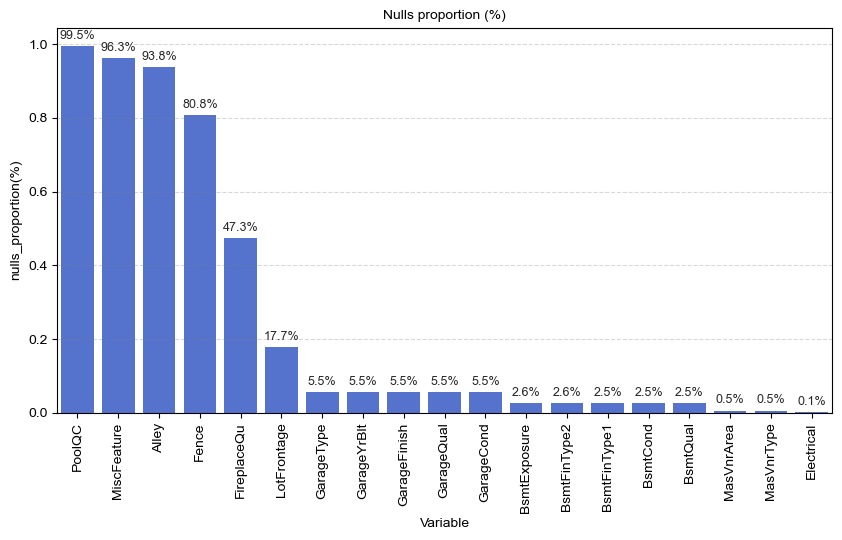

In [19]:
# Nulls proportion
df = func_get_nulls(df_housesales)
df['nulls_proportion(%)'] = df['nulls_proportion(%)']/100

plt.figure(figsize = (10,5))
ax = sns.barplot(data=df, x='variable', y='nulls_proportion(%)', color='royalblue', errwidth=0)
plt.title('Nulls proportion (%)', fontsize=10)
plt.xlabel('Variable')
plt.xticks(rotation=90)
plt.grid(color='gray', linestyle='--', linewidth=0.8, axis='y', alpha=0.3)
sns.set_style("whitegrid")
#plt.yticks(np.arange(0,0.31,0.05))

for i,v in (enumerate(df['nulls_proportion(%)'])):
  ax.text(i
          ,v+0.02
          ,str(round((v*100),1))+'%'
          ,fontsize=9
          ,ha='center')

plt.show()

In [20]:
# Checking unique values
func_get_unique_values(df_housesales, unique_umbral=20)

Number of variables with unique values >= 20 : 24 out of 81


variable  unique_count  unique_proportion(%)
69      3SsnPorch            20                 1.370
75        MiscVal            21                 1.438
45   LowQualFinSF            24                 1.644
12   Neighborhood            25                 1.712
20   YearRemodAdd            61                 4.178
70    ScreenPorch            76                 5.205
59    GarageYrBlt            97                 6.644
3     LotFrontage           110                 7.534
19      YearBuilt           112                 7.671
68  EnclosedPorch           120                 8.219
36     BsmtFinSF2           144                 9.863
67    OpenPorchSF           202                13.836
66     WoodDeckSF           274                18.767
26     MasVnrArea           327                22.397
44       2ndFlrSF           417                28.562
62     GarageArea           441                30.205
34     BsmtFinSF1           637                43.630
80      SalePrice           663                45.411
38    TotalBsmtSF           721                49.384
43       1stFlrSF           753                51.575
37      BsmtUnfSF           780                53.425
46      GrLivArea           861                58.973
4         LotArea          1073                73.493
0              Id          1460               100.000

In [21]:
# EDA Summary
df_basic_eda = func_basic_eda(df_housesales)

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df_basic_eda)

variable    dtype  unique  unique_proportion  nulls  \
0              Id   object    1460           1.000000      0   
1      MSSubClass   object      15           0.010274      0   
2        MSZoning   object       5           0.003425      0   
3     LotFrontage  float64     111           0.076027    259   
4         LotArea    int64    1073           0.734932      0   
5          Street   object       2           0.001370      0   
6           Alley   object       3           0.002055   1369   
7        LotShape   object       4           0.002740      0   
8     LandContour   object       4           0.002740      0   
9       Utilities   object       2           0.001370      0   
10      LotConfig   object       5           0.003425      0   
11      LandSlope   object       3           0.002055      0   
12   Neighborhood   object      25           0.017123      0   
13     Condition1   object       9           0.006164      0   
14     Condition2   object       8           0.005479      0   
15       BldgType   object       5           0.003425      0   
16     HouseStyle   object       8           0.005479      0   
17    OverallQual    int64      10           0.006849      0   
18    OverallCond    int64       9           0.006164      0   
19      YearBuilt   object     112           0.076712      0   
20   YearRemodAdd   object      61           0.041781      0   
21      RoofStyle   object       6           0.004110      0   
22       RoofMatl   object       8           0.005479      0   
23    Exterior1st   object      15           0.010274      0   
24    Exterior2nd   object      16           0.010959      0   
25     MasVnrType   object       5           0.003425      8   
26     MasVnrArea  float64     328           0.224658      8   
27      ExterQual   object       4           0.002740      0   
28      ExterCond   object       5           0.003425      0   
29     Foundation   object       6           0.004110      0   
30       BsmtQual   object       5           0.003425     37   
31       BsmtCond   object       5           0.003425     37   
32   BsmtExposure   object       5           0.003425     38   
33   BsmtFinType1   object       7           0.004795     37   
34     BsmtFinSF1    int64     637           0.436301      0   
35   BsmtFinType2   object       7           0.004795     38   
36     BsmtFinSF2    int64     144           0.098630      0   
37      BsmtUnfSF    int64     780           0.534247      0   
38    TotalBsmtSF    int64     721           0.493836      0   
39        Heating   object       6           0.004110      0   
40      HeatingQC   object       5           0.003425      0   
41     CentralAir   object       2           0.001370      0   
42     Electrical   object       6           0.004110      1   
43       1stFlrSF    int64     753           0.515753      0   
44       2ndFlrSF    int64     417           0.285616      0   
45   LowQualFinSF    int64      24           0.016438      0   
46      GrLivArea    int64     861           0.589726      0   
47   BsmtFullBath    int64       4           0.002740      0   
48   BsmtHalfBath    int64       3           0.002055      0   
49       FullBath    int64       4           0.002740      0   
50       HalfBath    int64       3           0.002055      0   
51   BedroomAbvGr    int64       8           0.005479      0   
52   KitchenAbvGr    int64       4           0.002740      0   
53    KitchenQual   object       4           0.002740      0   
54   TotRmsAbvGrd    int64      12           0.008219      0   
55     Functional   object       7           0.004795      0   
56     Fireplaces    int64       4           0.002740      0   
57    FireplaceQu   object       6           0.004110    690   
58     GarageType   object       7           0.004795     81   
59    GarageYrBlt   object      98           0.067123     81   
60   GarageFinish   object       4           0.002740     81   
61     GarageCars    int64       5       

### 4.1. Numeric variables


In [22]:
# Basic statistic on numeric variables
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df_housesales.describe())

LotFrontage        LotArea  OverallQual  OverallCond   MasVnrArea  \
count  1201.000000    1460.000000  1460.000000  1460.000000  1452.000000   
mean     70.049958   10516.828082     6.099315     5.575342   103.685262   
std      24.284752    9981.264932     1.382997     1.112799   181.066207   
min      21.000000    1300.000000     1.000000     1.000000     0.000000   
25%      59.000000    7553.500000     5.000000     5.000000     0.000000   
50%      69.000000    9478.500000     6.000000     5.000000     0.000000   
75%      80.000000   11601.500000     7.000000     6.000000   166.000000   
max     313.000000  215245.000000    10.000000     9.000000  1600.000000   

        BsmtFinSF1   BsmtFinSF2    BsmtUnfSF  TotalBsmtSF     1stFlrSF  \
count  1460.000000  1460.000000  1460.000000  1460.000000  1460.000000   
mean    443.639726    46.549315   567.240411  1057.429452  1162.626712   
std     456.098091   161.319273   441.866955   438.705324   386.587738   
min       0.000000     0.000000     0.000000     0.000000   334.000000   
25%       0.000000     0.000000   223.000000   795.750000   882.000000   
50%     383.500000     0.000000   477.500000   991.500000  1087.000000   
75%     712.250000     0.000000   808.000000  1298.250000  1391.250000   
max    5644.000000  1474.000000  2336.000000  6110.000000  4692.000000   

          2ndFlrSF  LowQualFinSF    GrLivArea  BsmtFullBath  BsmtHalfBath  \
count  1460.000000   1460.000000  1460.000000   1460.000000   1460.000000   
mean    346.992466      5.844521  1515.463699      0.425342      0.057534   
std     436.528436     48.623081   525.480383      0.518911      0.238753   
min       0.000000      0.000000   334.000000      0.000000      0.000000   
25%       0.000000      0.000000  1129.500000      0.000000      0.000000   
50%       0.000000      0.000000  1464.000000      0.000000      0.000000   
75%     728.000000      0.000000  1776.750000      1.000000      0.000000   
max    2065.000000    572.000000  5642.000000      3.000000      2.000000   

          FullBath     HalfBath  BedroomAbvGr  KitchenAbvGr  TotRmsAbvGrd  \
count  1460.000000  1460.000000   1460.000000   1460.000000   1460.000000   
mean      1.565068     0.382877      2.866438      1.046575      6.517808   
std       0.550916     0.502885      0.815778      0.220338      1.625393   
min       0.000000     0.000000      0.000000      0.000000      2.000000   
25%       1.000000     0.000000      2.000000      1.000000      5.000000   
50%       2.000000     0.000000      3.000000      1.000000      6.000000   
75%       2.000000     1.000000      3.000000      1.000000      7.000000   
max       3.000000     2.000000      8.000000      3.000000     14.000000   

        Fireplaces   GarageCars   GarageArea   WoodDeckSF  OpenPorchSF  \
count  1460.000000  1460.000000  1460.000000  1460.000000  1460.000000   
mean      0.613014     1.767123   472.980137    94.244521    46.660274   
std       0.644666     0.747315   213.804841   125.338794    66.256028   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     1.000000   334.500000     0.000000     0.000000   
50%       1.000000     2.000000   480.000000     0.000000    25.000000   
75%       1.000000     2.000000   576.000000   168.000000    68.000000   
max       3.000000     4.000000  1418.000000   857.000000   547.000000   

       EnclosedPorch    3SsnPorch  ScreenPorch     PoolArea       MiscVal  \
count    1460.000000  1460.000000  1460.000000  1460.000000   1460.000000   
mean       21.954110     3.409589    15.060959     2.758904     43.489041   
std        61.119149    29.317331    55.757415    40.177307    496.123024   
min         0.000000     0.000000     0.000000     0.000000      0.000000   
25%         0.000000     0.000000     0.000000     0.000000      0.000000   
50%         0.000000     0.000000     0.000000     0.000000      0.000000   
75%         0.000000     0.000000     0.000000     0.000000  

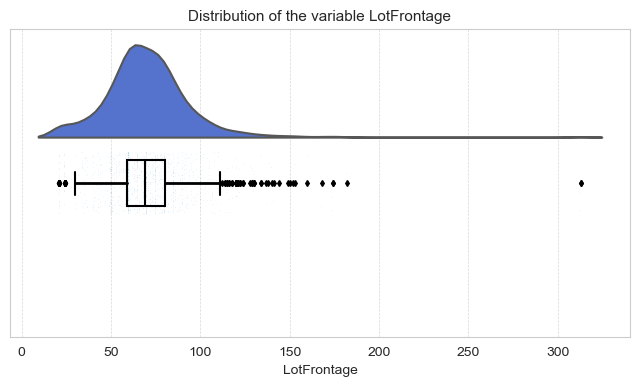

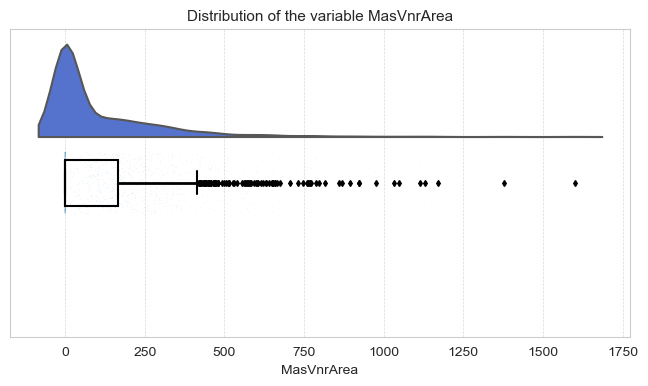

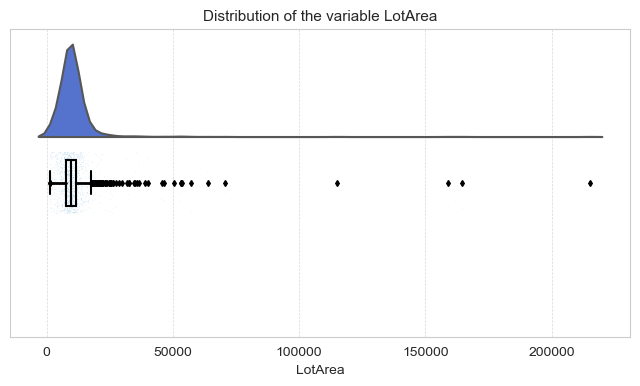

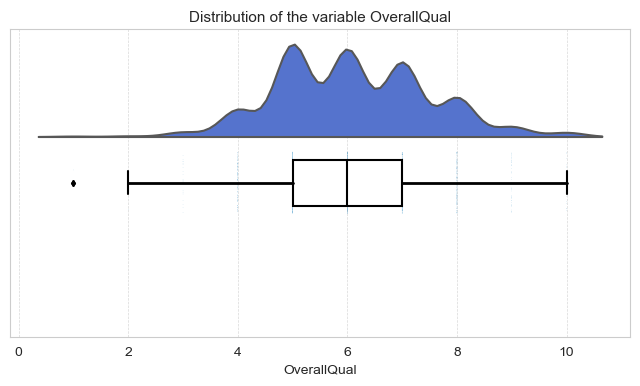

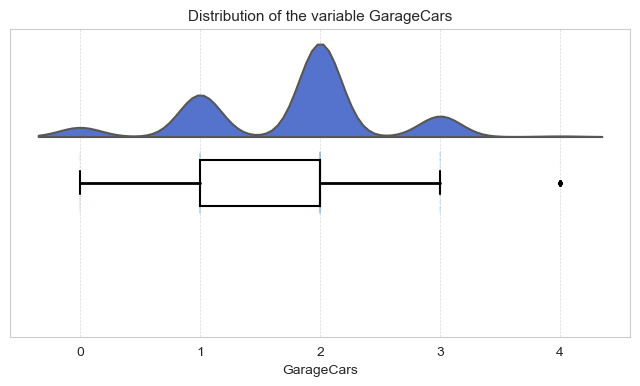

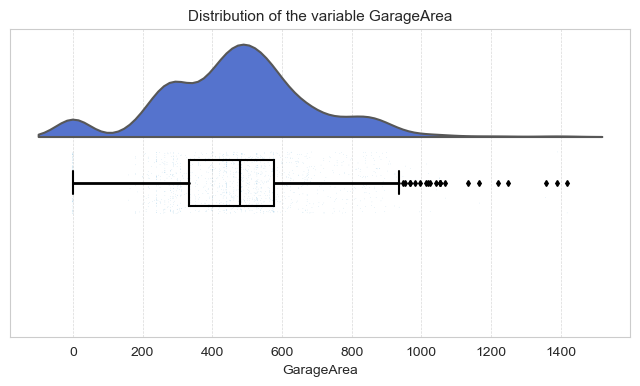

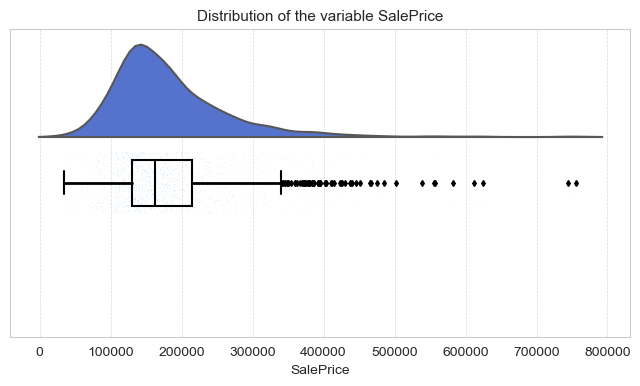

In [23]:
# Boxplot and Density
num_columns_to_analyze = ['LotFrontage', 'MasVnrArea','LotArea', 'OverallQual', 'GarageCars', 'GarageArea','SalePrice']
for col in num_columns_to_analyze:
    func_box_plot(df = df_housesales, var=col)

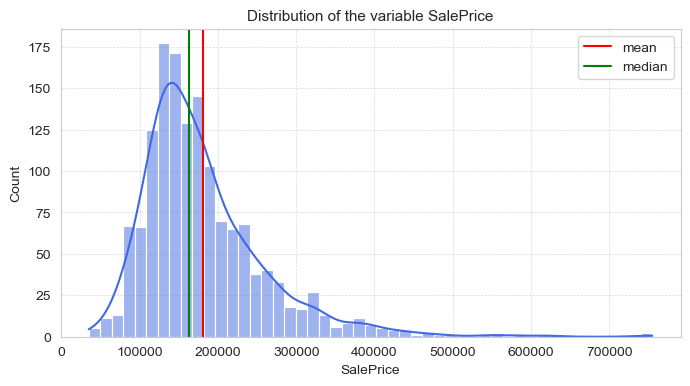

In [24]:
# Histplot of SalePrice (target)
func_hist_plot(df=df_housesales, var_x='SalePrice')

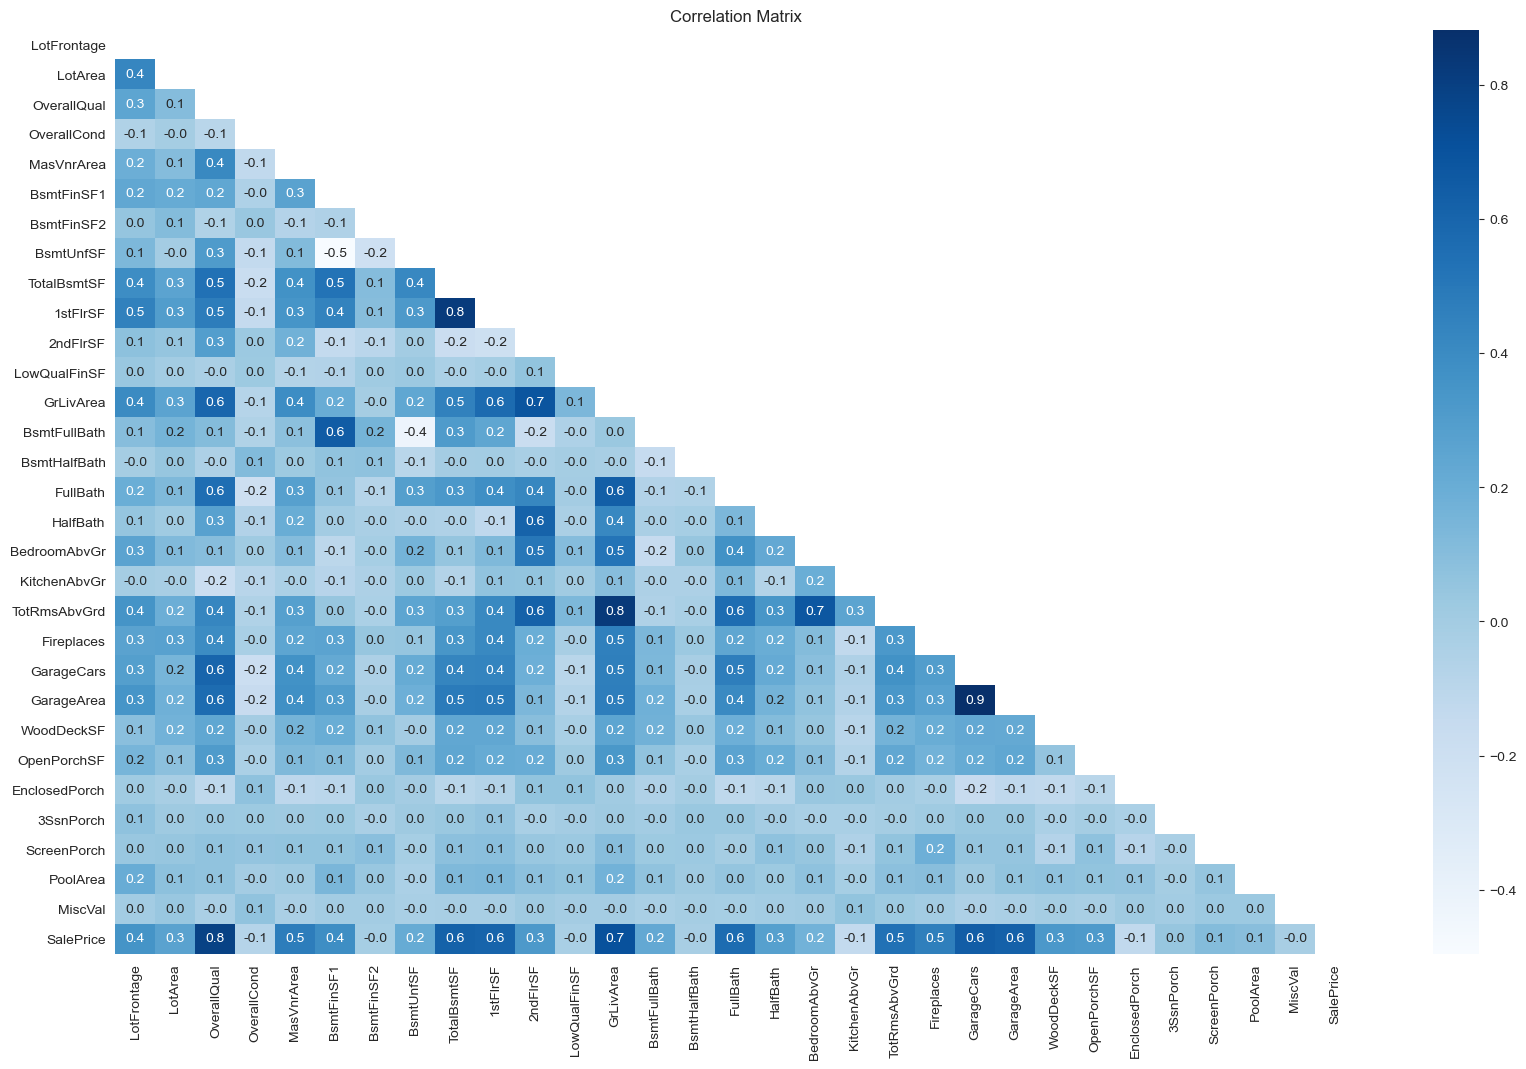

In [25]:
# Correlation
corr = df_housesales[numeric_columns].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=[20,12])
sns.heatmap(corr, mask=mask, annot=True, fmt='.1f', cmap='Blues') #, fmt=".3f"
plt.title('Correlation Matrix')
plt.show()

In [26]:
# Correlation | Top 20
c = df_housesales[numeric_columns].corr().abs()
s = pd.DataFrame(c.unstack()).reset_index()
s = s[s['level_0']!=s['level_1']].rename(columns={'level_0':'var_1', 'level_1':'var_2', 0:'corr_abs'})
s = s.sort_values(by='corr_abs', ascending=False)
s = s.drop_duplicates('corr_abs', keep='first').reset_index(drop=True).head(20)
s

var_1         var_2  corr_abs
0     GarageCars    GarageArea  0.882475
1      GrLivArea  TotRmsAbvGrd  0.825489
2       1stFlrSF   TotalBsmtSF  0.819530
3    OverallQual     SalePrice  0.790982
4      SalePrice     GrLivArea  0.708624
5       2ndFlrSF     GrLivArea  0.687501
6   TotRmsAbvGrd  BedroomAbvGr  0.676620
7   BsmtFullBath    BsmtFinSF1  0.649212
8      SalePrice    GarageCars  0.640409
9      GrLivArea      FullBath  0.630012
10     SalePrice    GarageArea  0.623431
11  TotRmsAbvGrd      2ndFlrSF  0.616423
12     SalePrice   TotalBsmtSF  0.613581
13      HalfBath      2ndFlrSF  0.609707
14     SalePrice      1stFlrSF  0.605852
15   OverallQual    GarageCars  0.600671
16     GrLivArea   OverallQual  0.593007
17      1stFlrSF     GrLivArea  0.566024
18    GarageArea   OverallQual  0.562022
19      FullBath     SalePrice  0.560664

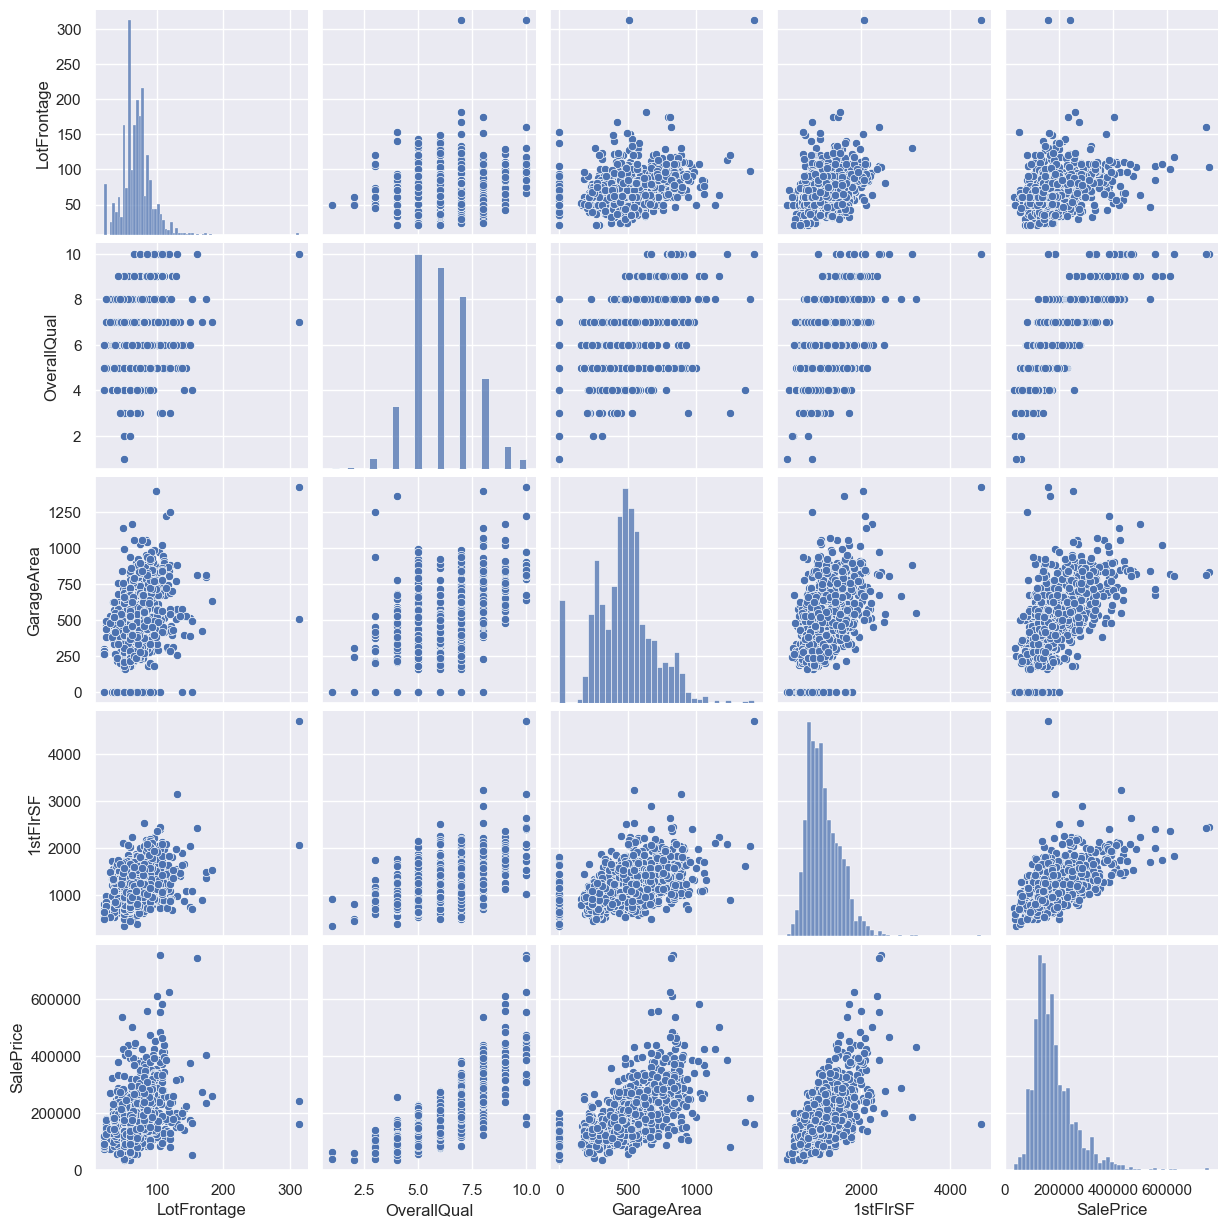

In [27]:
# Pairplots
sns.set(rc={'figure.figsize':(8,6)})

cols= ['LotFrontage','OverallQual', 'GarageArea', '1stFlrSF','SalePrice']

sns.pairplot(data = df_housesales, vars=cols)
sns.set_style("darkgrid")
plt.show()

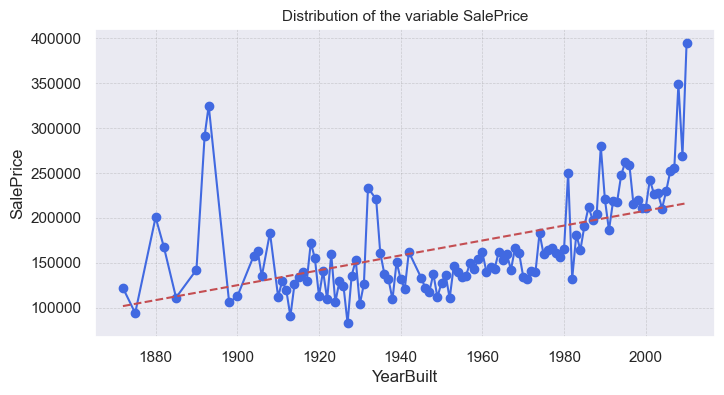

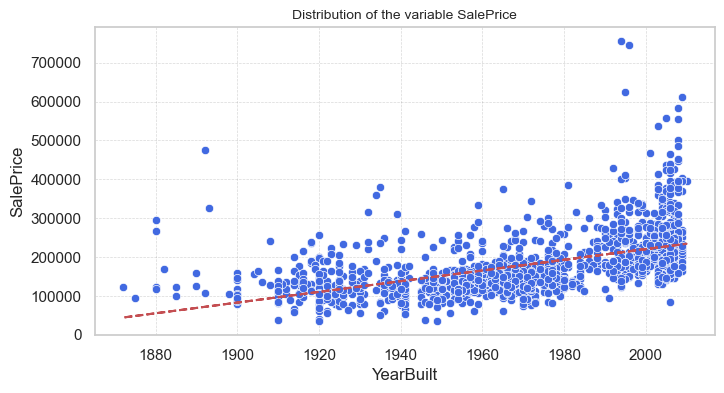

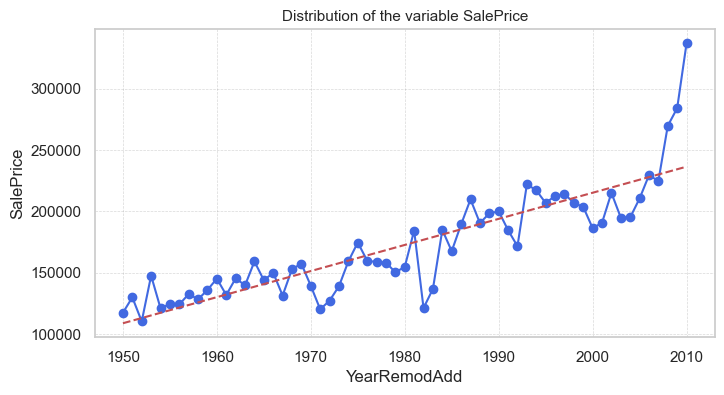

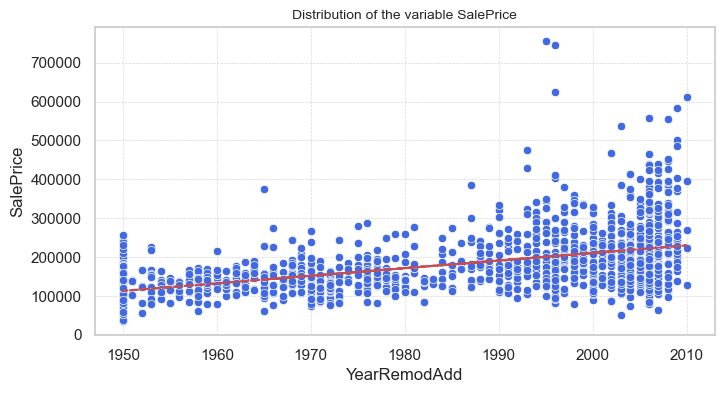

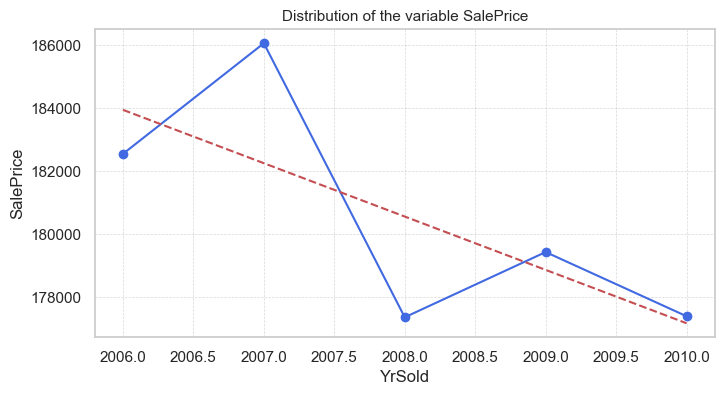

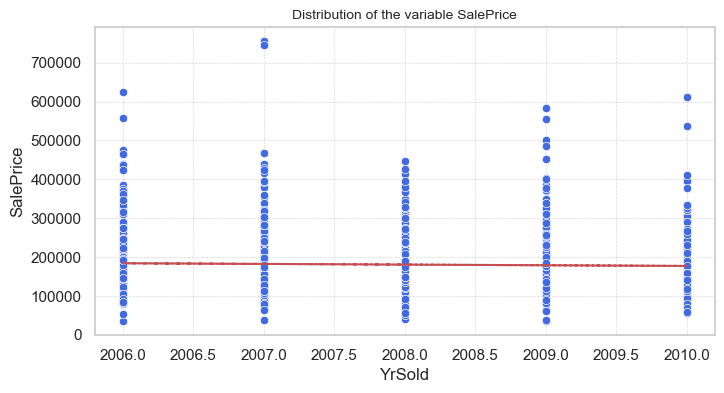

In [28]:
# Lineplot Scatterplot and Trends (Sales grouped by mean)
columns_date_to_analyze = ['YearBuilt', 'YearRemodAdd', 'YrSold']
columns_num_to_analyze = ['SalePrice']

for col1 in columns_num_to_analyze:
    for col2 in columns_date_to_analyze:
        df_h = df_housesales.copy()
        df_h[col1] = df_h[col1].astype(float)
        df = df_h.groupby(col2, as_index=False)[col1].mean()
        func_line_plot(df=df, var_x=col2, var_y=col1, rotation=0)
        func_scatter_plot(df=df_housesales, var_x=col2, var_y=col1, rotation=0)

### 4.2. Categorical variables

In [29]:
# Basic statistic on categorical variables
cat_df = df_basic_eda[df_basic_eda['dtype']=='object'][['variable','dtype','mode','example']].set_index('variable')
cat_df_t = cat_df.transpose()

print(f"Shape: {cat_df.shape[0]}")

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(cat_df_t)

Shape: 50


variable                   Id       MSSubClass             MSZoning  \
dtype                  object           object               object   
mode                        1               20                   RL   
example   1223,64,470,803,930  85,80,160,90,90  RH,C (all),RH,FV,RH   

variable                    Street                   Alley  \
dtype                       object                  object   
mode                          Pave                    Grvl   
example   Pave,Grvl,Pave,Grvl,Pave  nan,Pave,Pave,Pave,nan   

variable             LotShape          LandContour  \
dtype                  object               object   
mode                      Reg                  Lvl   
example   Reg,IR1,Reg,Reg,Reg  Low,Lvl,Low,Bnk,Lvl   

variable                           Utilities  \
dtype                                 object   
mode                                  AllPub   
example   AllPub,AllPub,AllPub,AllPub,NoSeWa   

variable                         LotConfig            LandSlope  \
dtype                               object               object   
mode                                Inside                  Gtl   
example   Corner,CulDSac,FR2,Inside,Corner  Sev,Gtl,Mod,Sev,Sev   

variable                           Neighborhood                  Condition1  \
dtype                                    object                      object   
mode                                      NAmes                        Norm   
example   StoneBr,Edwards,Crawfor,Edwards,NAmes  RRNn,RRAn,Feedr,Feedr,PosN   

variable                 Condition2                        BldgType  \
dtype                        object                          object   
mode                           Norm                            1Fam   
example   RRAn,RRAn,Feedr,PosA,RRAn  1Fam,2fmCon,Duplex,1Fam,Duplex   

variable                      HouseStyle                 YearBuilt  \
dtype                             object                    object   
mode                              1Story                      2006   
example   SLvl,2.5Unf,SFoyer,SFoyer,SLvl  2004,1961,1919,1981,1931   

variable              YearRemodAdd                    RoofStyle  \
dtype                       object                       object   
mode                          1950                        Gable   
example   1995,1979,2007,1983,1990  Gable,Hip,Gable,Gable,Gable   

variable                            RoofMatl  \
dtype                                 object   
mode                                 CompShg   
example   Roll,Tar&Grv,Metal,WdShngl,CompShg   

variable                             Exterior1st  \
dtype                                     object   
mode                                     VinylSd   
example   Stucco,BrkComm,Wd Sdng,AsphShn,HdBoard   

variable                             Exterior2nd  \
dtype                                     object   
mode                                     VinylSd   
example   Wd Sdng,Plywood,ImStucc,HdBoard,Stucco   

variable                           MasVnrType       ExterQual       ExterCond  \
dtype                                  object          object          object   
mode                                     None              TA              TA   
example   BrkCmn,BrkFace,None,BrkFace,BrkFace  Fa,Ex,Gd,Fa,TA  Ex,Fa,Fa,Ex,Fa   

variable                      Foundation        BsmtQual         BsmtCond  \
dtype                             object          object           object   
mode                               PConc              TA               TA   
example   PConc,BrkTil,PConc,PConc,PConc  Gd,Gd,Gd,TA,Fa  Fa,nan,Gd,TA,Fa   

variable      BsmtExposure         BsmtFinType1         BsmtFinType2  \
dtype               object               object               object   
mode                    No                  Unf                  Unf   
example   Gd,nan,Mn,Mn,nan  LwQ,GLQ,LwQ,ALQ,Unf  ALQ,Unf,ALQ,ALQ,GLQ   

variable                   Heating       HeatingQC CentralAir  \
dtype                       object  

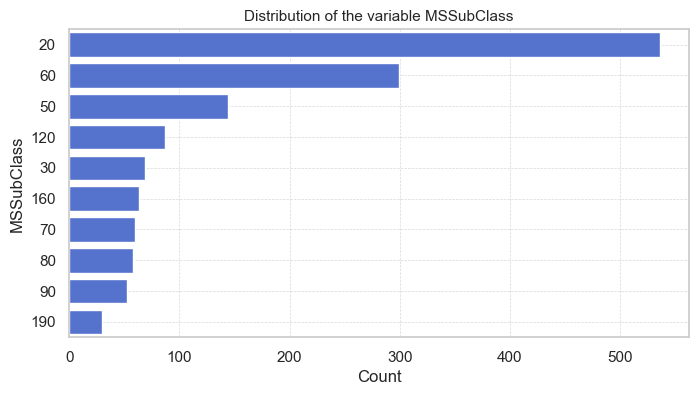

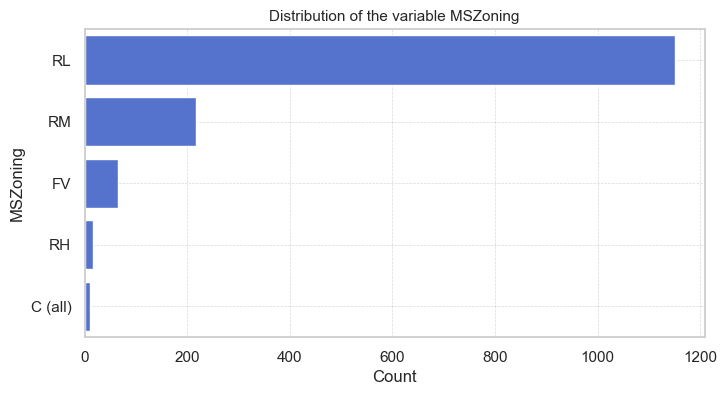

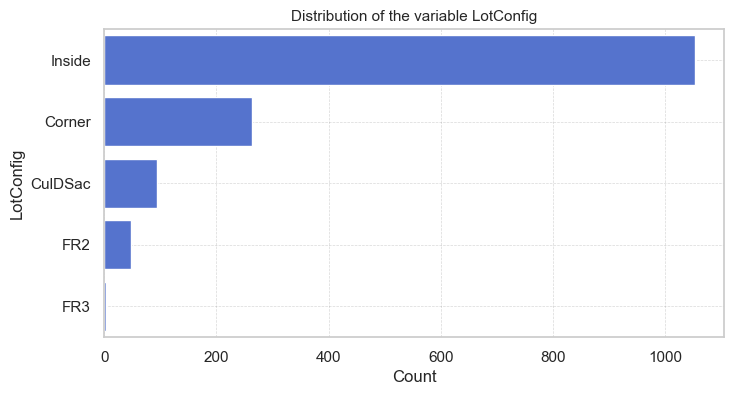

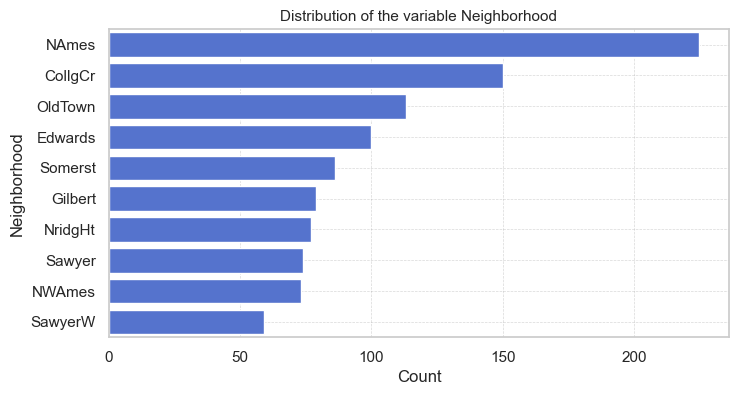

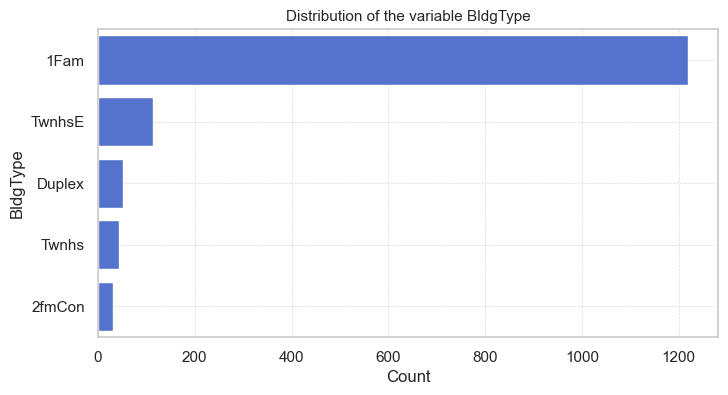

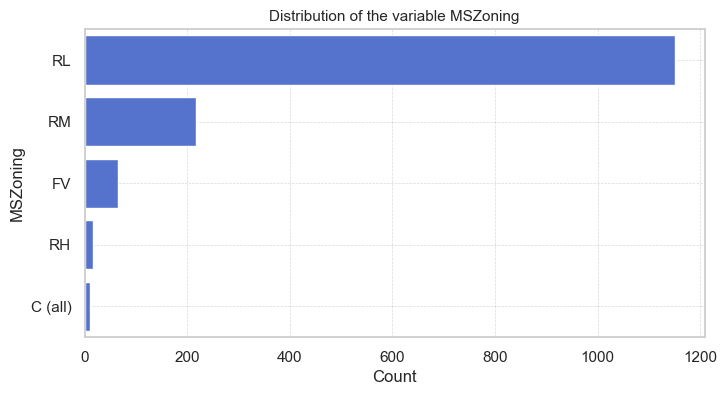

In [30]:
# Barplots and Frequency
cat_columns_to_analyze = ['MSSubClass', 'MSZoning', 'LotConfig', 'Neighborhood', 'BldgType', 'MSZoning']
for col in cat_columns_to_analyze:
    func_bar_plot(df = df_housesales, var=col)

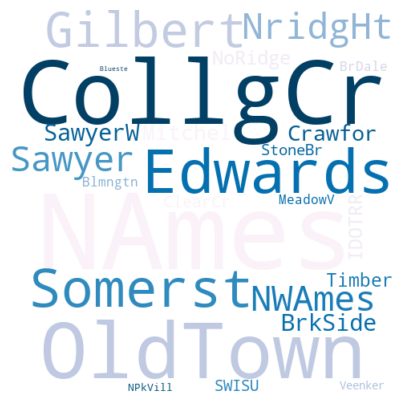

In [31]:
# Word cloud (Neighborhood)
corpus = ''
for sentence in df_housesales['Neighborhood']:
  texto = re.sub(r'[^a-zA-Z]', ' ', sentence)
  texto = texto + ' '
  corpus = corpus + texto

corpus = re.sub(' +', ' ', corpus)

## Object
wordcloud = WordCloud(width=480, height=480, margin=0,background_color='white',mode="RGBA", colormap='PuBu').generate(corpus) #, max_font_size=70, max_words=50

## Plots
plt.figure(figsize=(5,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

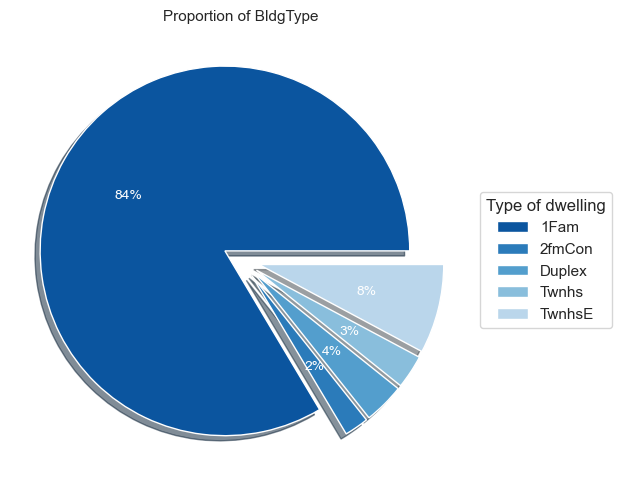

In [32]:
# Pie Chart
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(aspect="equal"))

var = 'BldgType'
var_desc = 'Type of dwelling'
df = df_housesales.groupby(var, as_index=False)['Id'].count().rename(columns={'Id':'Count'})

types = [i for i in df[var]]
wedges, texts, autotexts = ax.pie(df['Count'], labels = df[var], colors = sns.color_palette('Blues')[::-1]
                                    , autopct='%.0f%%', labeldistance=None, explode=[0.1,0.1,0.1,0.1,0.1], shadow=True,textprops=dict(color="w"))

plt.setp(autotexts, size=10)
ax.set_title(f"Proportion of {var}", fontdict={'fontsize':11})
ax.legend(wedges, types,
          title=var_desc,
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))
plt.show()

### 4.3. Bivariate analysis

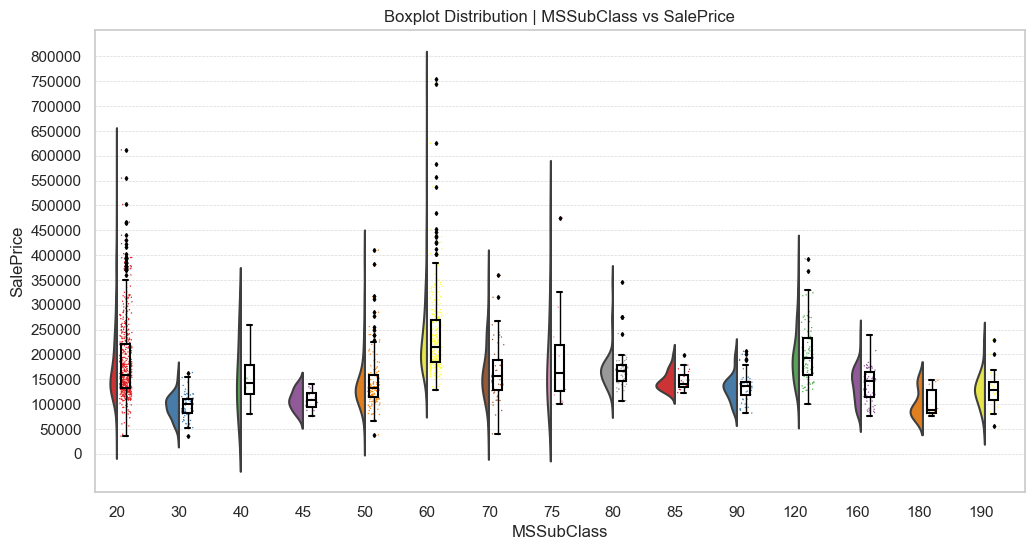

In [33]:
# SalePrice Boxplot - MSSubClass
f, ax = plt.subplots(figsize=(12, 6))
df = df_housesales.copy()

df['MSSubClass'] = df['MSSubClass'].astype(int)
df.sort_values(by='MSSubClass', ascending=True, inplace=True)


pal = "Set1" #GnBu #Set2 #RdBu
dx = "MSSubClass"
dy = "SalePrice"

ax = pt.half_violinplot( x = dx, y = dy, data = df, width = .6, palette = pal, scale = "area", inner = None)
ax = sns.stripplot( x = dx, y = dy, data = df, jitter=1, palette = pal, edgecolor = "white", size = 1 , zorder = 0)
ax = sns.boxplot(x=dx, y=dy,data = df, width = .15, color = "black", zorder = 10, showcaps = True, fliersize=2,
                 boxprops = {'facecolor':'none', "zorder":10}, showfliers=True, whiskerprops = {'linewidth':1, "zorder":10},saturation = 1)

ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha="right")
plt.title('Boxplot Distribution | MSSubClass vs SalePrice')
plt.ylabel('SalePrice')
plt.xlabel('MSSubClass')
plt.yticks(range(0,800001,50000))
plt.grid(color='gray', linestyle='--', linewidth=0.5, axis='y', alpha=0.3)
plt.show()

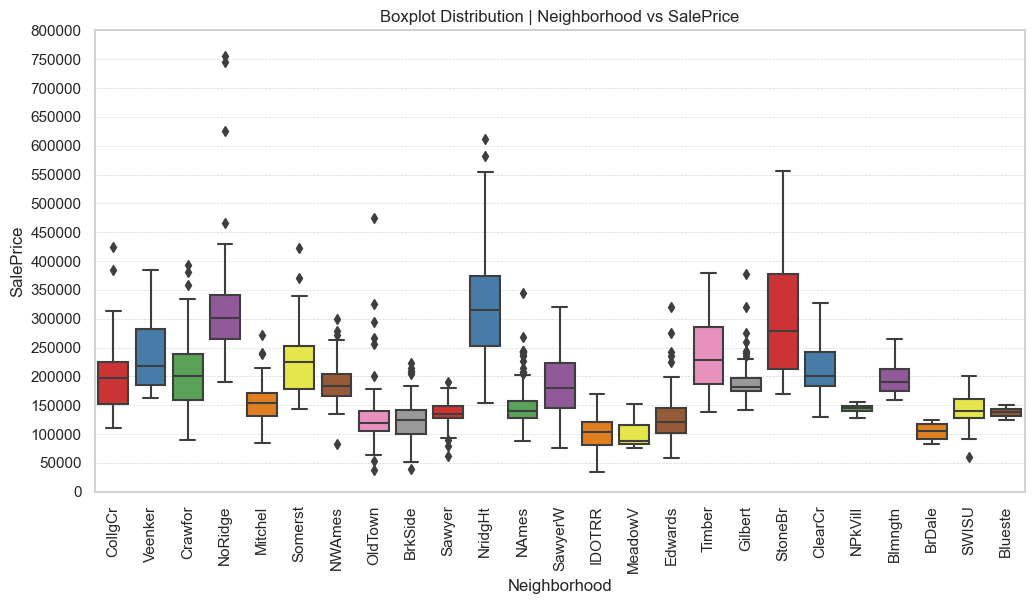

In [34]:
# SalePrice Boxplot - Neighborhoods

# SalePrice Boxplot
plt.figure(figsize = (12,6))
sns.boxplot(data=df_housesales, x="Neighborhood", y="SalePrice", palette="Set1")
plt.title('Boxplot Distribution | Neighborhood vs SalePrice')
sns.set_style("whitegrid")
plt.xticks(rotation=90)
plt.yticks(range(0,800001,50000))
plt.grid(color='gray', linestyle='--', linewidth=0.5, axis='y', alpha=0.3)
plt.show()

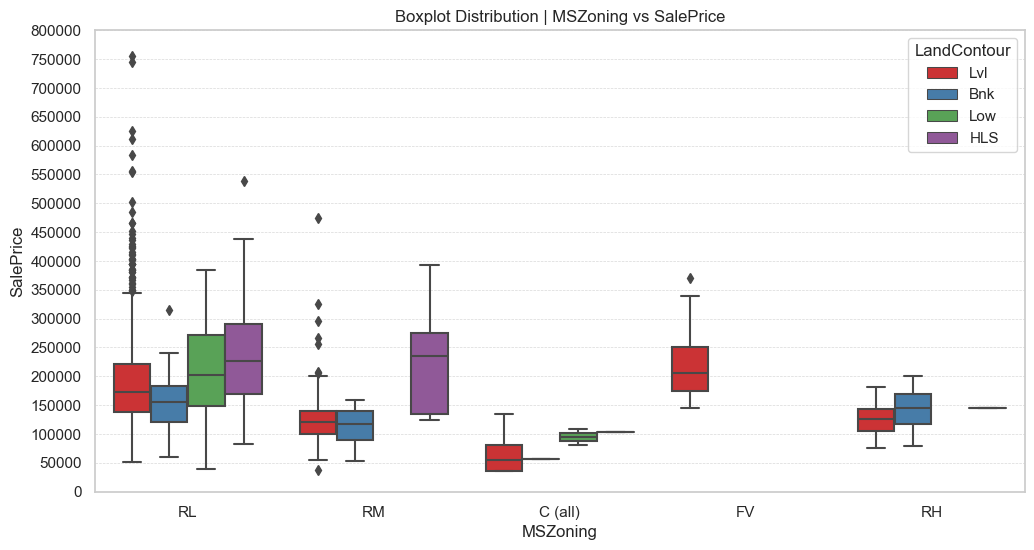

In [35]:
# SalePrice Boxplot - MSZoning
plt.figure(figsize = (12,6))
sns.boxplot(data=df_housesales, x="MSZoning", y="SalePrice", palette="Set1", hue="LandContour")
plt.title('Boxplot Distribution | MSZoning vs SalePrice')
sns.set_style("whitegrid")
plt.yticks(range(0,800001,50000))
plt.grid(color='gray', linestyle='--', linewidth=0.5, axis='y', alpha=0.3)
plt.show()

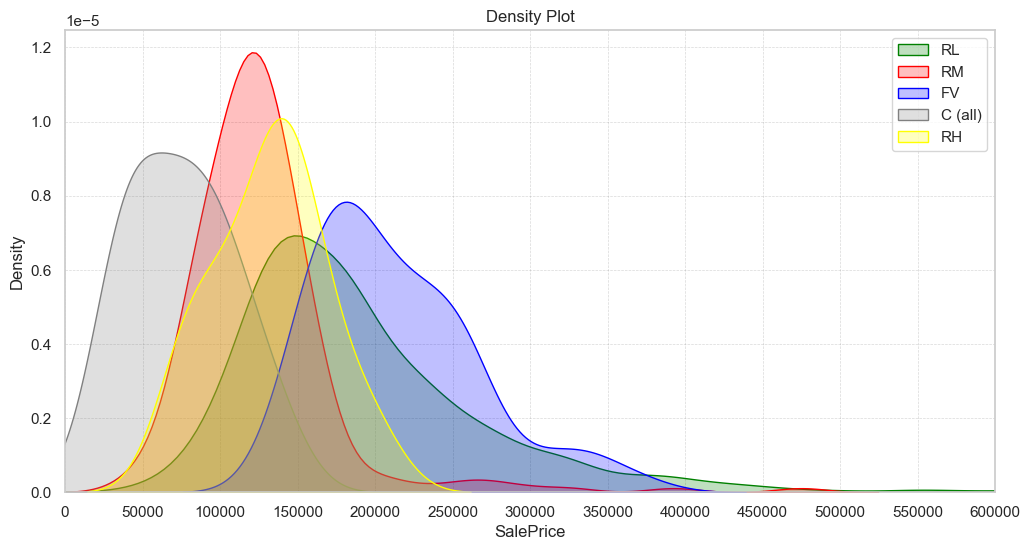

In [36]:
# Density of SalePrice - MSZoning 
plt.figure(figsize=(12,6))
sns.kdeplot(df_housesales["SalePrice"][df_housesales['MSZoning'] == 'RL'], color="green", shade=True)
sns.kdeplot(df_housesales["SalePrice"][df_housesales['MSZoning'] == 'RM'], color="red", shade=True)
sns.kdeplot(df_housesales["SalePrice"][df_housesales['MSZoning'] == 'FV'], color="blue", shade=True)
sns.kdeplot(df_housesales["SalePrice"][df_housesales['MSZoning'] == 'C (all)'], color="gray", shade=True)
sns.kdeplot(df_housesales["SalePrice"][df_housesales['MSZoning'] == 'RH'], color="yellow", shade=True)

plt.legend(['RL', 'RM', 'FV', 'C (all)', 'RH'])
plt.title('Density Plot')

plt.xlim(-20,600000)
plt.xticks(range(0,600001,50000))
plt.grid(color='gray', linestyle='--', linewidth=0.5, axis='both', alpha=0.3)
plt.show()

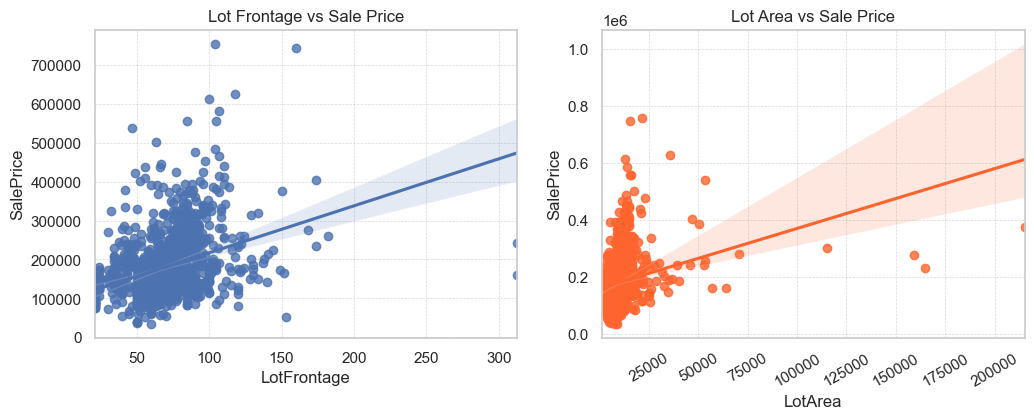

In [37]:
# Regplot of SalesPrice
plt.figure(figsize=(12,4))
plt.subplot(121)
ax1 = sns.regplot(x="LotFrontage", y="SalePrice", data=df_housesales)
ax1.set_title("Lot Frontage vs Sale Price")
plt.grid(color='gray', linestyle='--', linewidth=0.5, axis='both', alpha=0.3)

plt.subplot(122)
ax2 = sns.regplot(x="LotArea", y="SalePrice", data=df_housesales, color='#FE642E')
ax2.set_title("Lot Area vs Sale Price")
plt.xticks(rotation=30)
plt.grid(color='gray', linestyle='--', linewidth=0.5, axis='both', alpha=0.3)
plt.show()

## 5. Transformations

### 5.1. Nulls treatment

#### Drop nan columns

In [38]:
# As we saw before, there are some variables with a high level of missing values
## Our first transformation will be dropping all the variables with over 40% of nulls

df1 = df_housesales.copy()

df_nulls_40p = df_nulls[df_nulls['nulls_proportion(%)']>40]
list_var_nulls_40p = list(df_nulls_40p['variable'])

print(f'Variables with over 40% of nulls: {list_var_nulls_40p}')

# Drop columns > 40% nulls
df1.drop(columns=list_var_nulls_40p, inplace=True)

print(f'Original shape: {df_housesales.shape}')
print(f'Shape post alter: {df1.shape}')

# Showing the columns we just dropped
df_nulls_40p

Variables with over 40% of nulls: ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu']
Original shape: (1460, 81)
Shape post alter: (1460, 76)


variable  nulls_count  nulls_proportion(%)
72       PoolQC         1453               99.521
74  MiscFeature         1406               96.301
6         Alley         1369               93.767
73        Fence         1179               80.753
57  FireplaceQu          690               47.260

In [39]:
# Checking the changes (and showing the columns that still have nulls)
still_nulls = func_get_nulls(df1)
still_nulls

Number of variables with nulls: 14


variable  nulls_count  nulls_proportion(%)
3    LotFrontage          259               17.740
56    GarageType           81                5.548
57   GarageYrBlt           81                5.548
58  GarageFinish           81                5.548
61    GarageQual           81                5.548
62    GarageCond           81                5.548
31  BsmtExposure           38                2.603
34  BsmtFinType2           38                2.603
29      BsmtQual           37                2.534
30      BsmtCond           37                2.534
32  BsmtFinType1           37                2.534
24    MasVnrType            8                0.548
25    MasVnrArea            8                0.548
41    Electrical            1                0.068

In [40]:
# Checking dtypes from the above columns
list_still_nulls = still_nulls['variable']
df_still_nulls = df_basic_eda[df_basic_eda['variable'].isin(list_still_nulls)].sort_values(by='dtype')
df_still_nulls

variable    dtype  unique  unique_proportion  nulls  nulls_proportion  \
3    LotFrontage  float64     111           0.076027    259          0.177397   
26    MasVnrArea  float64     328           0.224658      8          0.005479   
25    MasVnrType   object       5           0.003425      8          0.005479   
30      BsmtQual   object       5           0.003425     37          0.025342   
31      BsmtCond   object       5           0.003425     37          0.025342   
32  BsmtExposure   object       5           0.003425     38          0.026027   
33  BsmtFinType1   object       7           0.004795     37          0.025342   
35  BsmtFinType2   object       7           0.004795     38          0.026027   
42    Electrical   object       6           0.004110      1          0.000685   
58    GarageType   object       7           0.004795     81          0.055479   
59   GarageYrBlt   object      98           0.067123     81          0.055479   
60  GarageFinish   object       4           0.002740     81          0.055479   
63    GarageQual   object       6           0.004110     81          0.055479   
64    GarageCond   object       6           0.004110     81          0.055479   

    median        mean         std     max   min     zeros    mode  \
3     69.0   70.049958   24.284752   313.0  21.0  0.000000    60.0   
26     0.0  103.685262  181.066207  1600.0   0.0  0.589726     0.0   
25     NaN         NaN         NaN     NaN   NaN       NaN    None   
30     NaN         NaN         NaN     NaN   NaN       NaN      TA   
31     NaN         NaN         NaN     NaN   NaN       NaN      TA   
32     NaN         NaN         NaN     NaN   NaN       NaN      No   
33     NaN         NaN         NaN     NaN   NaN       NaN     Unf   
35     NaN         NaN         NaN     NaN   NaN       NaN     Unf   
42     NaN         NaN         NaN     NaN   NaN       NaN   SBrkr   
58     NaN         NaN         NaN     NaN   NaN       NaN  Attchd   
59     NaN         NaN         NaN     NaN   NaN       NaN    2005   
60     NaN         NaN         NaN     NaN   NaN       NaN     Unf   
63     NaN         NaN         NaN     NaN   NaN       NaN      TA   
64     NaN         NaN         NaN     NaN   NaN       NaN      TA   

                                example  
3             106.0,68.0,68.0,61.0,36.0  
26        443.0,1115.0,748.0,41.0,167.0  
25  BrkCmn,BrkFace,None,BrkFace,BrkFace  
30                       Gd,Gd,Gd,TA,Fa  
31                      Fa,nan,Gd,TA,Fa  
32                     Gd,nan,Mn,Mn,nan  
33                  LwQ,GLQ,LwQ,ALQ,Unf  
35                  ALQ,Unf,ALQ,ALQ,GLQ  
42            FuseA,Mix,SBrkr,Mix,FuseF  
58  Basment,Attchd,2Types,2Types,Attchd  
59              1994,1930,nan,1959,1955  
60                  nan,RFn,nan,RFn,Unf  
63                       TA,Gd,Fa,Po,Gd  
64                      nan,Fa,TA,Gd,Po

#### Drop rows

In [41]:
# Drop Dataframe rows containing either 75% or more NaN values
perc = 75.0 
min_count =  int(((100-perc)/100)*df1.shape[1] + 1)

print(f'Shape pre alter: {df1.shape}')
df1 = df1.dropna(axis=0, thresh=min_count)

print(f'Shape post alter: {df1.shape}')

Shape pre alter: (1460, 76)
Shape post alter: (1460, 76)


#### Impute nan rows

In [42]:
# The strategy will be this: 

## For the float dtypes, we will impute the nan values using the median

for var in ['LotFrontage','MasVnrArea']:
    df1[var].fillna(df1[var].median(), inplace=True)

## For the object dtypes, we will impute the nan values using the mode, except for the 'GarageYrBlt which will be imputed using the 'YearBuilt' var (correlated)

df1['GarageYrBlt'].fillna(df1['YearBuilt'], inplace=True)

for var in list(df_still_nulls[df_still_nulls['dtype']=='object']['variable']):
    df1[var].fillna(df1[var].mode()[0], inplace=True)

In [43]:
# Checking nulls again
func_get_nulls(df1)

Number of variables with nulls: 0


Empty DataFrame
Columns: [variable, nulls_count, nulls_proportion(%)]
Index: []

### 5.2. New features

#### 5.2.1. YearMonthSold

In [44]:
# Generating the feature YearMonthSold
df2 = df1.copy()

df2['MoSold'] = df2['MoSold'].apply(lambda x: '0'+str(x) if int(x)<10 else str(x))
df2['YearMonthSold'] = df2['YrSold'].astype(str) + '-' + df2['MoSold'].astype(str)

df2.head()

Id MSSubClass MSZoning  LotFrontage  LotArea Street LotShape LandContour  \
0  1         60       RL         65.0     8450   Pave      Reg         Lvl   
1  2         20       RL         80.0     9600   Pave      Reg         Lvl   
2  3         60       RL         68.0    11250   Pave      IR1         Lvl   
3  4         70       RL         60.0     9550   Pave      IR1         Lvl   
4  5         60       RL         84.0    14260   Pave      IR1         Lvl   

  Utilities LotConfig  ... 3SsnPorch ScreenPorch PoolArea MiscVal MoSold  \
0    AllPub    Inside  ...         0           0        0       0     02   
1    AllPub       FR2  ...         0           0        0       0     05   
2    AllPub    Inside  ...         0           0        0       0     09   
3    AllPub    Corner  ...         0           0        0       0     02   
4    AllPub       FR2  ...         0           0        0       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  YearMonthSold  
0   2008        WD         Normal     208500        2008-02  
1   2007        WD         Normal     181500        2007-05  
2   2008        WD         Normal     223500        2008-09  
3   2006        WD        Abnorml     140000        2006-02  
4   2008        WD         Normal     250000        2008-12  

[5 rows x 77 columns]

Unique values: 55


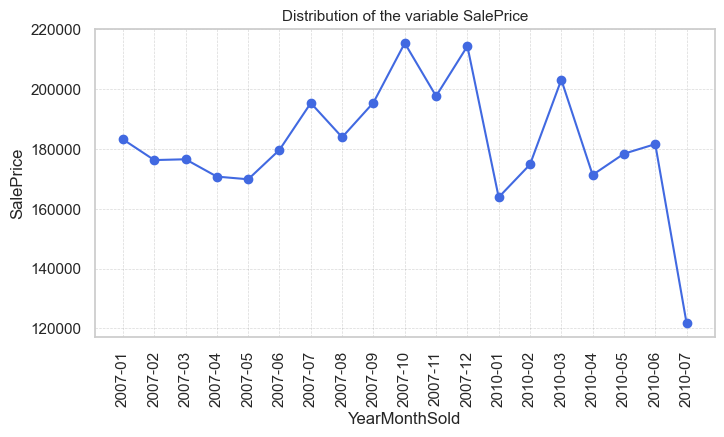

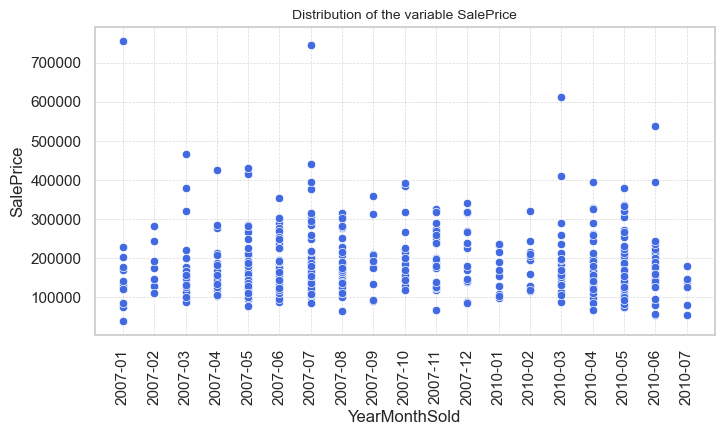

In [45]:
# Analyzing the feature YearMonthSold

print(f"Unique values: {df2['YearMonthSold'].nunique()}")

t = df2[df2['YrSold'].isin([2007,2010])]

# Lineplot Scatterplot and Trends (Sales grouped by mean)
columns_date_to_analyze = ['YearMonthSold']
columns_num_to_analyze = ['SalePrice']

for col1 in columns_num_to_analyze:
    for col2 in columns_date_to_analyze:
        df = t.groupby(col2, as_index=False)[col1].mean()
        func_line_plot(df=df, var_x=col2, var_y=col1, trend=False, rotation=90, x_as_int=False)
        func_scatter_plot(df=t.sort_values(by=['YrSold','MoSold']), var_x=col2, var_y=col1, trend=False, rotation=90, x_as_int=False)

#### 5.2.2. GarageArea_div_GarageCars

In [46]:
# Based on correlation we saw this
s.head(1)

var_1       var_2  corr_abs
0  GarageCars  GarageArea  0.882475

Shape pre alter: (1460, 77)
Shape post alter: (1460, 76)


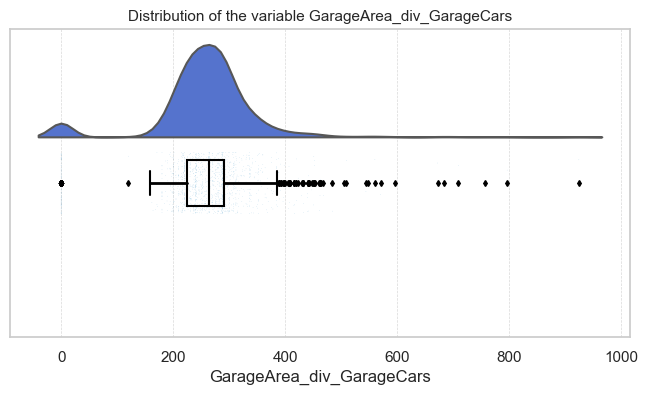

In [47]:
# Generating the feature GarageArea_div_GarageCars
df3 = df2.copy()

# We create a variable that combines both of them
df3['GarageArea_div_GarageCars'] = df3['GarageArea'] / df3['GarageCars']
df3['GarageArea_div_GarageCars'].fillna(0, inplace=True)

# And we drop the original ones
df3.drop(labels=['GarageArea', 'GarageCars'], axis=1, inplace=True)

# Shapes

print(f"Shape pre alter: {df2.shape}")
print(f"Shape post alter: {df3.shape}")

# Checking distribution
func_box_plot(df = df3, var='GarageArea_div_GarageCars')

### 5.3. Data preprocessed

In [48]:
# Data preprocessed
# data_preprocessed = df3.copy()
data_preprocessed = df1.copy()  # Not incorporing "YearMonthSold" and "GarageArea_div_GarageCars" variables

with pd.option_context('display.max_rows', 5, 'display.max_columns', None):
    display(data_preprocessed)

Id MSSubClass MSZoning  LotFrontage  LotArea Street LotShape  \
0        1         60       RL         65.0     8450   Pave      Reg   
1        2         20       RL         80.0     9600   Pave      Reg   
...    ...        ...      ...          ...      ...    ...      ...   
1458  1459         20       RL         68.0     9717   Pave      Reg   
1459  1460         20       RL         75.0     9937   Pave      Reg   

     LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0            Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
1            Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
...          ...       ...       ...       ...          ...        ...   
1458         Lvl    AllPub    Inside       Gtl        NAmes       Norm   
1459         Lvl    AllPub    Inside       Gtl      Edwards       Norm   

     Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
0          Norm     1Fam     2Story            7            5       2003   
1          Norm     1Fam     1Story            6            8       1976   
...         ...      ...        ...          ...          ...        ...   
1458       Norm     1Fam     1Story            5            6       1950   
1459       Norm     1Fam     1Story            5            6       1965   

      YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
0             2003     Gable  CompShg     VinylSd     VinylSd    BrkFace   
1             1976     Gable  CompShg     MetalSd     MetalSd       None   
...            ...       ...      ...         ...         ...        ...   
1458          1996       Hip  CompShg     MetalSd     MetalSd       None   
1459          1965     Gable  CompShg     HdBoard     HdBoard       None   

      MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond  \
0          196.0        Gd        TA      PConc       Gd       TA   
1            0.0        TA        TA     CBlock       Gd       TA   
...          ...       ...       ...        ...      ...      ...   
1458         0.0        TA        TA     CBlock       TA       TA   
1459         0.0        Gd        TA     CBlock       TA       TA   

     BsmtExposure BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  \
0              No          GLQ         706          Unf           0   
1              Gd          ALQ         978          Unf           0   
...           ...          ...         ...          ...         ...   
1458           Mn          GLQ          49          Rec        1029   
1459           No          BLQ         830          LwQ         290   

      BsmtUnfSF  TotalBsmtSF Heating HeatingQC CentralAir Electrical  \
0           150          856    GasA        Ex          Y      SBrkr   
1           284         1262    GasA        Ex          Y      SBrkr   
...         ...          ...     ...       ...        ...        ...   
1458          0         1078    GasA        Gd          Y      FuseA   
1459        136         1256    GasA        Gd          Y      SBrkr   

      1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  BsmtHalfBath  \
0          856       854             0       1710             1             0   
1         1262         0             0       1262             0             1   
...        ...       ...           ...        ...           ...           ...   
1458      1078         0             0       1078             1             0   
1459      1256         0             0       1256             1             0   

      FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr KitchenQual  \
0            2         1             3             1          Gd   
1            2         0             3             1          TA   
...        ...       ...           ...           ...         ...   
1458         1         0             2             1          Gd   
1459         1         1             3             1          TA   

      TotRmsAbvGrd Functional  Fireplaces Gar

In [49]:
# Summary of all information from above
df_basic_eda_2 = func_basic_eda(data_preprocessed)

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df_basic_eda_2)

variable    dtype  unique  unique_proportion  nulls  \
0              Id   object    1460           1.000000      0   
1      MSSubClass   object      15           0.010274      0   
2        MSZoning   object       5           0.003425      0   
3     LotFrontage  float64     110           0.075342      0   
4         LotArea    int64    1073           0.734932      0   
5          Street   object       2           0.001370      0   
6        LotShape   object       4           0.002740      0   
7     LandContour   object       4           0.002740      0   
8       Utilities   object       2           0.001370      0   
9       LotConfig   object       5           0.003425      0   
10      LandSlope   object       3           0.002055      0   
11   Neighborhood   object      25           0.017123      0   
12     Condition1   object       9           0.006164      0   
13     Condition2   object       8           0.005479      0   
14       BldgType   object       5           0.003425      0   
15     HouseStyle   object       8           0.005479      0   
16    OverallQual    int64      10           0.006849      0   
17    OverallCond    int64       9           0.006164      0   
18      YearBuilt    int32     112           0.076712      0   
19   YearRemodAdd    int32      61           0.041781      0   
20      RoofStyle   object       6           0.004110      0   
21       RoofMatl   object       8           0.005479      0   
22    Exterior1st   object      15           0.010274      0   
23    Exterior2nd   object      16           0.010959      0   
24     MasVnrType   object       4           0.002740      0   
25     MasVnrArea  float64     327           0.223973      0   
26      ExterQual   object       4           0.002740      0   
27      ExterCond   object       5           0.003425      0   
28     Foundation   object       6           0.004110      0   
29       BsmtQual   object       4           0.002740      0   
30       BsmtCond   object       4           0.002740      0   
31   BsmtExposure   object       4           0.002740      0   
32   BsmtFinType1   object       6           0.004110      0   
33     BsmtFinSF1    int64     637           0.436301      0   
34   BsmtFinType2   object       6           0.004110      0   
35     BsmtFinSF2    int64     144           0.098630      0   
36      BsmtUnfSF    int64     780           0.534247      0   
37    TotalBsmtSF    int64     721           0.493836      0   
38        Heating   object       6           0.004110      0   
39      HeatingQC   object       5           0.003425      0   
40     CentralAir   object       2           0.001370      0   
41     Electrical   object       5           0.003425      0   
42       1stFlrSF    int64     753           0.515753      0   
43       2ndFlrSF    int64     417           0.285616      0   
44   LowQualFinSF    int64      24           0.016438      0   
45      GrLivArea    int64     861           0.589726      0   
46   BsmtFullBath    int64       4           0.002740      0   
47   BsmtHalfBath    int64       3           0.002055      0   
48       FullBath    int64       4           0.002740      0   
49       HalfBath    int64       3           0.002055      0   
50   BedroomAbvGr    int64       8           0.005479      0   
51   KitchenAbvGr    int64       4           0.002740      0   
52    KitchenQual   object       4           0.002740      0   
53   TotRmsAbvGrd    int64      12           0.008219      0   
54     Functional   object       7           0.004795      0   
55     Fireplaces    int64       4           0.002740      0   
56     GarageType   object       6           0.004110      0   
57    GarageYrBlt   object     146           0.100000      0   
58   GarageFinish   object       3           0.002055      0   
59     GarageCars    int64       5           0.003425      0   
60     GarageArea    int64     441           0.302055      0   
61     GarageQual   object       5       

In [50]:
# Final correlation | Top 10
numeric_columns = data_preprocessed.select_dtypes(exclude='object').columns.to_list()

c = data_preprocessed[numeric_columns].corr().abs()
s = pd.DataFrame(c.unstack()).reset_index()
s = s[s['level_0']!=s['level_1']].rename(columns={'level_0':'var_1', 'level_1':'var_2', 0:'corr_abs'})
s = s.sort_values(by='corr_abs', ascending=False)
s = s.drop_duplicates('corr_abs', keep='first').reset_index(drop=True).head(10)
s

var_1         var_2  corr_abs
0    GarageCars    GarageArea  0.882475
1  TotRmsAbvGrd     GrLivArea  0.825489
2      1stFlrSF   TotalBsmtSF  0.819530
3   OverallQual     SalePrice  0.790982
4     GrLivArea     SalePrice  0.708624
5      2ndFlrSF     GrLivArea  0.687501
6  BedroomAbvGr  TotRmsAbvGrd  0.676620
7    BsmtFinSF1  BsmtFullBath  0.649212
8     SalePrice    GarageCars  0.640409
9     GrLivArea      FullBath  0.630012

## 6. Modeling

We will try 3 boosting algorithms:

* XGBRegressor
* LGBMRegressor
* CatBoostRegressor



## 6.0. Pre-modeling

Before modeling we need to do a little of extra work, dropping columns we won't use, scaling numeric data and transforming categorical columns into bools (dummies)

In [84]:
# Classifying columns
df_pre_models = data_preprocessed.copy()

nums_to_cat = ['YearBuilt', 'YearRemodAdd', 'YrSold']
for var in nums_to_cat:
    df_pre_models[var] = df_pre_models[var].astype(str)

cols_at_end = ['SalePrice']
df_pre_models = df_pre_models[[c for c in df_pre_models if c not in cols_at_end] + [c for c in cols_at_end if c in df_pre_models]]

# Dtypes
total_columns = df_pre_models.columns.to_list()
numeric_columns = df_pre_models.select_dtypes(exclude='object').columns.to_list()
categorical_columns = df_pre_models.select_dtypes(include='object').columns.to_list()

## Shape
print(f'Shape df_pre_models: {df_pre_models.shape}\n')

## Numeric values 
print(f'Dtypes: Numeric Columns({len(numeric_columns)} out of {len(total_columns)})')
print(numeric_columns)
print('\n')
## Categorical values 
print(f'Dtypes: Categorical Columns({len(categorical_columns)} out of {len(total_columns)})')
print(categorical_columns)

Shape df_pre_models: (1460, 76)

Dtypes: Numeric Columns(31 out of 76)
['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'SalePrice']


Dtypes: Categorical Columns(45 out of 76)
['Id', 'MSSubClass', 'MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'Kitchen

In [85]:
# Classifying columns
label = ['SalePrice']
useless = ['Id']
numerical = [i for i in numeric_columns if i not in label]
categorical = [i for i in categorical_columns if i not in useless]

# Use the function "clean_data" to create X and y
X, y = clean_data(data=df_pre_models, label_column = label, useless_columns = useless, num_columns = numerical, cat_columns=categorical) 

print(f'Shape X: {X.shape}')
print(f'Shape y: {y.shape}')

Shape X: (1460, 527)
Shape y: (1460,)


In [86]:
X.head(3)

LotFrontage  LotArea  OverallQual  OverallCond  MasVnrArea  BsmtFinSF1  \
0         65.0     8450            7            5       196.0         706   
1         80.0     9600            6            8         0.0         978   
2         68.0    11250            7            5       162.0         486   

   BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  1stFlrSF  ...  SaleType_ConLI  \
0           0        150          856       856  ...               0   
1           0        284         1262      1262  ...               0   
2           0        434          920       920  ...               0   

   SaleType_ConLw  SaleType_New  SaleType_Oth  SaleType_WD  \
0               0             0             0            1   
1               0             0             0            1   
2               0             0             0            1   

   SaleCondition_AdjLand  SaleCondition_Alloca  SaleCondition_Family  \
0                      0                     0                     0   
1                      0                     0                     0   
2                      0                     0                     0   

   SaleCondition_Normal  SaleCondition_Partial  
0                     1                      0  
1                     1                      0  
2                     1                      0  

[3 rows x 527 columns]

In [87]:
y.head(3)

0    208500
1    181500
2    223500
Name: SalePrice, dtype: int64

In [88]:
# Checking if there's duplicates columns
import collections
a = X.columns.to_list()
print([item for item, count in collections.Counter(a).items() if count > 1])

[]


In [89]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f'Shape X_train: {X_train.shape}')
print(f'Shape y_train: {y_train.shape}\n')

print(f'Shape X_test: {X_test.shape}')
print(f'Shape y_test: {y_test.shape}')

Shape X_train: (1168, 527)
Shape y_train: (1168,)

Shape X_test: (292, 527)
Shape y_test: (292,)


##### ¿Scaling or not? 

According to references, it is not require to scale numerical variables when we use algorithms like Decision Tree and Ensemble Techniques, because splitting in these cases are based on the values.

So, our models will use X_train and X_test datasets. However, next is the way to scale the data in case you are interested, specially when we have dummy variables.

In [90]:
# Scaling numeric features | Training dataset
scaler = MinMaxScaler()

dummies = ([i for i in X_train.columns.to_list() if i not in numerical])

# Scaling only on the numerical variables ("numerical" is a list we defined above)
X_train_scaled_pre = scaler.fit_transform(X_train[numerical])
X_train_scaled_pre = pd.DataFrame(X_train_scaled_pre, columns = numerical)

# Merging to get all scaled columns + dummies columns
X_train_scaled = pd.merge(X_train_scaled_pre.reset_index(drop=True), X_train[dummies].reset_index(drop=True), how='inner', left_index=True, right_index=True)
print(f'Shape X_train_scaled: {X_train_scaled.shape}')

X_train_scaled.head(3)

Shape X_train_scaled: (1168, 527)


LotFrontage   LotArea  OverallQual  OverallCond  MasVnrArea  BsmtFinSF1  \
0     0.167808  0.033186     0.444444        0.625         0.0    0.163359   
1     0.130137  0.030555     0.555556        0.750         0.0    0.000000   
2     0.157534  0.034948     0.444444        0.750         0.0    0.000000   

   BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  1stFlrSF  ...  SaleType_ConLI  \
0         0.0   0.167808     0.215057  0.224874  ...               0   
1         0.0   0.342038     0.130769  0.106700  ...               0   
2         0.0   0.340753     0.130278  0.106012  ...               0   

   SaleType_ConLw  SaleType_New  SaleType_Oth  SaleType_WD  \
0               0             0             0            1   
1               0             0             0            1   
2               0             0             0            1   

   SaleCondition_AdjLand  SaleCondition_Alloca  SaleCondition_Family  \
0                      0                     0                     0   
1                      0                     0                     0   
2                      0                     0                     0   

   SaleCondition_Normal  SaleCondition_Partial  
0                     1                      0  
1                     1                      0  
2                     1                      0  

[3 rows x 527 columns]

In [91]:
# Scaling numeric features | Testing dataset
dummies = ([i for i in X_train.columns.to_list() if i not in numerical])

# Scaling only on the numerical variables based on the scaler applied on the training dataset ("numerical" is a list we defined above)
X_test_scaled_pre = scaler.transform(X_test[numerical])
X_test_scaled_pre = pd.DataFrame(X_test_scaled_pre, columns = numerical)

# Merging to get all scaled columns + dummies columns
X_test_scaled = pd.merge(X_test_scaled_pre.reset_index(drop=True), X_test[dummies].reset_index(drop=True), how='inner', left_index=True, right_index=True)
print(f'Shape X_test_scaled: {X_test_scaled.shape}')

X_test_scaled.head(3)

Shape X_test_scaled: (292, 527)


LotFrontage   LotArea  OverallQual  OverallCond  MasVnrArea  BsmtFinSF1  \
0     0.167808  0.033252     0.555556        0.875      0.0000    0.117470   
1     0.263699  0.051209     0.777778        0.500      0.2627    0.182849   
2     0.119863  0.035804     0.444444        0.625      0.0000    0.000000   

   BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  1stFlrSF  ...  SaleType_ConLI  \
0         0.0   0.169521     0.173322  0.168426  ...               0   
1         0.0   0.184503     0.239444  0.267554  ...               0   
2         0.0   0.431507     0.164975  0.159247  ...               0   

   SaleType_ConLw  SaleType_New  SaleType_Oth  SaleType_WD  \
0               0             0             0            1   
1               0             0             0            1   
2               0             0             0            1   

   SaleCondition_AdjLand  SaleCondition_Alloca  SaleCondition_Family  \
0                      0                     0                     0   
1                      0                     0                     0   
2                      0                     0                     0   

   SaleCondition_Normal  SaleCondition_Partial  
0                     1                      0  
1                     1                      0  
2                     1                      0  

[3 rows x 527 columns]

## 6.1. XGBoostRegressor


In [109]:
# Hyperparameter Tuning
def optuna_xgboost(trial):
  '''Hyperparameter Tuning | Function to find the best combitation of hyperparameters based on a list of them'''
  
  # Normal X_train and y_train
  X, y = X_train, y_train

  # Parameters
  param = {
        'max_depth': trial.suggest_int('max_depth', 1, 50),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 10, 500),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0.01, 1.0),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 1.0),
        # 'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 1.0),
        # 'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 1.0),
        'random_state':42
    }
  
  # Model
  model = xgb.XGBRegressor(**param)

  # Score | RMSE by applying cross-validation
  score = np.sqrt(-cross_val_score(estimator = model, X=X, y=y, scoring='neg_mean_squared_error', cv=5)).mean()

  return score

In [106]:
%%time
# Setting the experiment to find the best hyperparameters combination
model_name = 'XGBoost'
optuna_model = optuna_xgboost

study_xgboost= optuna.create_study(study_name = f'Hyperparameter Optimization | {model_name}',direction = "minimize")
study_xgboost.optimize(optuna_model, n_trials = 30)

# Print the best parameters
print('Best parameters', study_xgboost.best_params)

# Print the best value
print('\nBest value', study_xgboost.best_value)

[I 2022-12-21 17:30:10,214] A new study created in memory with name: Hyperparameter Optimization | XGBoost
[I 2022-12-21 17:30:36,251] Trial 0 finished with value: 28212.072212277097 and parameters: {'max_depth': 40, 'learning_rate': 0.023150020350735698, 'n_estimators': 478, 'min_child_weight': 6, 'gamma': 0.440236575436322, 'subsample': 0.8924920531863362, 'colsample_bytree': 0.28381764801713166}. Best is trial 0 with value: 28212.072212277097.
[I 2022-12-21 17:30:42,141] Trial 1 finished with value: 30974.64047761857 and parameters: {'max_depth': 25, 'learning_rate': 0.1368049736723263, 'n_estimators': 71, 'min_child_weight': 3, 'gamma': 0.33055142222251543, 'subsample': 0.3539028634518202, 'colsample_bytree': 0.9657998264691738}. Best is trial 0 with value: 28212.072212277097.
[I 2022-12-21 17:30:47,406] Trial 2 finished with value: 33376.122406640854 and parameters: {'max_depth': 30, 'learning_rate': 0.28149444534330237, 'n_estimators': 45, 'min_child_weight': 1, 'gamma': 0.375208

Best parameters {'max_depth': 20, 'learning_rate': 0.03463845489991293, 'n_estimators': 241, 'min_child_weight': 8, 'gamma': 0.5393165429089533, 'subsample': 0.326163073386011, 'colsample_bytree': 0.29967874379171927}

Best value 27854.34764857851
Wall time: 25min 44s


In [94]:
# Plot contour
optuna.visualization.plot_contour(study_xgboost)

In [95]:
# Plot Hyperparameters importances
optuna.visualization.plot_param_importances(study_xgboost)

In [96]:
# Plot optimization history
optuna.visualization.plot_optimization_history(study_xgboost)

In [107]:
# Training the model based on the Hyperparameter Tuning

model_xgb = xgb.XGBRegressor(**study_xgboost.best_params)
model_xgb.fit(X_train, y_train)

y_pred = model_xgb.predict(X_test)

In [108]:
# Metrics on the test dataset
metrics_xgb = dict()

expected_y  = y_test.copy()
predicted_y = y_pred.copy()

metrics_xgb['rmse']     = [mean_squared_error(expected_y,predicted_y, squared=False)]
metrics_xgb['r2']       = [r2_score(expected_y,predicted_y)]
metrics_xgb['mae']      = [mean_absolute_error(expected_y, predicted_y)]
metrics_xgb['mse']      = [mean_squared_error(expected_y, predicted_y)]
metrics_xgb['mae_log']  = [mean_squared_log_error(expected_y, predicted_y)]

metrics_xgb = pd.DataFrame(metrics_xgb, columns=metrics_xgb.keys())
metrics_xgb

rmse        r2           mae           mse   mae_log
0  30905.318829  0.875476  17406.544962  9.551387e+08  0.021889

In [65]:
# Metrics on the test dataset
metrics_xgb = dict()

expected_y  = y_test.copy()
predicted_y = y_pred.copy()

metrics_xgb['rmse']     = [mean_squared_error(expected_y,predicted_y, squared=False)]
metrics_xgb['r2']       = [r2_score(expected_y,predicted_y)]
metrics_xgb['mae']      = [mean_absolute_error(expected_y, predicted_y)]
metrics_xgb['mse']      = [mean_squared_error(expected_y, predicted_y)]
metrics_xgb['mae_log']  = [mean_squared_log_error(expected_y, predicted_y)]

metrics_xgb = pd.DataFrame(metrics_xgb, columns=metrics_xgb.keys())
metrics_xgb

rmse        r2           mae           mse   mae_log
0  25882.459132  0.912663  15707.188142  6.699017e+08  0.018471

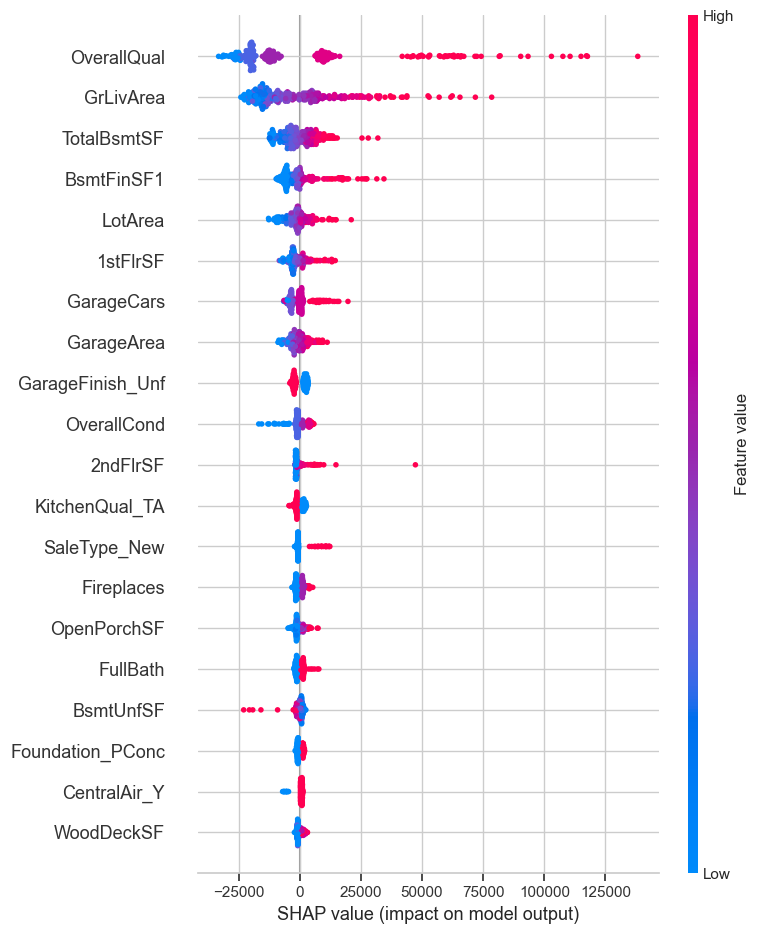

In [66]:
# Feature importance
model = model_xgb
X =  X_test
                       
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

shap.summary_plot(shap_values, X)
plt.show()

## 6.2. LGBMRegressor

In [67]:
# Hyperparameter Tuning
def optuna_lgbm(trial):
  '''Hyperparameter Tuning | Function to find the best combitation of hyperparameters based on a list of them'''
  
  # Normal X_train and y_train
  X, y = X_train, y_train

  # Parameters
  param = {
        'max_depth': trial.suggest_int('max_depth', 1, 30),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        #'gamma': trial.suggest_float('gamma', 0.01, 1.0),
        'subsample': trial.suggest_float('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 1.0),
        'random_state': trial.suggest_int('random_state', 1, 1000)
    }
  
  # Model
  model = LGBMRegressor(**param)

  # Score | RMSE by applying cross-validation
  score = np.sqrt(-cross_val_score(estimator = model, X=X, y=y, scoring='neg_mean_squared_error', cv=5)).mean()

  return score

In [68]:
%%time
# Setting the experiment to find the best hyperparameters combination
model_name = 'LGBM'
optuna_model = optuna_lgbm

study_lgbm = optuna.create_study(study_name = f'Hyperparameter Optimization | {model_name}',direction = "minimize")
study_lgbm.optimize(optuna_model, n_trials = 15)

# Print the best parameters
print('Best parameters', study_lgbm.best_params)

# Print the best value
print('\nBest value', study_lgbm.best_value)

[I 2022-12-21 14:46:23,134] A new study created in memory with name: Hyperparameter Optimization | LGBM
[I 2022-12-21 14:46:29,720] Trial 0 finished with value: 35379.476969036434 and parameters: {'max_depth': 23, 'learning_rate': 0.6907711552911336, 'n_estimators': 999, 'min_child_weight': 6, 'subsample': 0.20287742907532977, 'colsample_bytree': 0.7631633823241301, 'reg_alpha': 0.5766895312292379, 'reg_lambda': 0.2358712549109548, 'random_state': 67}. Best is trial 0 with value: 35379.476969036434.
[I 2022-12-21 14:46:36,332] Trial 1 finished with value: 38880.1001635304 and parameters: {'max_depth': 13, 'learning_rate': 0.7878846200633902, 'n_estimators': 854, 'min_child_weight': 1, 'subsample': 0.29699638066306294, 'colsample_bytree': 0.6539106606094064, 'reg_alpha': 0.7873598300638536, 'reg_lambda': 0.5756417523458772, 'random_state': 833}. Best is trial 0 with value: 35379.476969036434.
[I 2022-12-21 14:46:40,734] Trial 2 finished with value: 29558.67261836742 and parameters: {'ma

Best parameters {'max_depth': 3, 'learning_rate': 0.06492610952802516, 'n_estimators': 116, 'min_child_weight': 9, 'subsample': 0.6362514040378795, 'colsample_bytree': 0.41877784885346425, 'reg_alpha': 0.3775940471242572, 'reg_lambda': 0.9753177537911135, 'random_state': 381}

Best value 28706.88556766085
Wall time: 59.9 s


In [69]:
# Plot contour
optuna.visualization.plot_contour(study_lgbm)

In [70]:
# Plot Hyperparameters importances
optuna.visualization.plot_param_importances(study_lgbm)

In [71]:
# Plot optimization history
optuna.visualization.plot_optimization_history(study_lgbm)

In [72]:
# Training the model based on the Hyperparameter Tuning

model_lgbm = LGBMRegressor(**study_lgbm.best_params)
model_lgbm.fit(X_train, y_train)

y_pred = model_lgbm.predict(X_test)

In [73]:
# Metrics on the test dataset
metrics_lgbm = dict()

expected_y  = y_test.copy()
predicted_y = y_pred.copy()

metrics_lgbm['rmse']     = [mean_squared_error(expected_y,predicted_y, squared=False)]
metrics_lgbm['r2']       = [r2_score(expected_y,predicted_y)]
metrics_lgbm['mae']      = [mean_absolute_error(expected_y, predicted_y)]
metrics_lgbm['mse']      = [mean_squared_error(expected_y, predicted_y)]
metrics_lgbm['mae_log']  = [mean_squared_log_error(expected_y, predicted_y)]

metrics_lgbm = pd.DataFrame(metrics_lgbm, columns=metrics_lgbm.keys())
metrics_lgbm

rmse        r2           mae           mse   mae_log
0  29966.192378  0.882929  17952.538294  8.979727e+08  0.022183

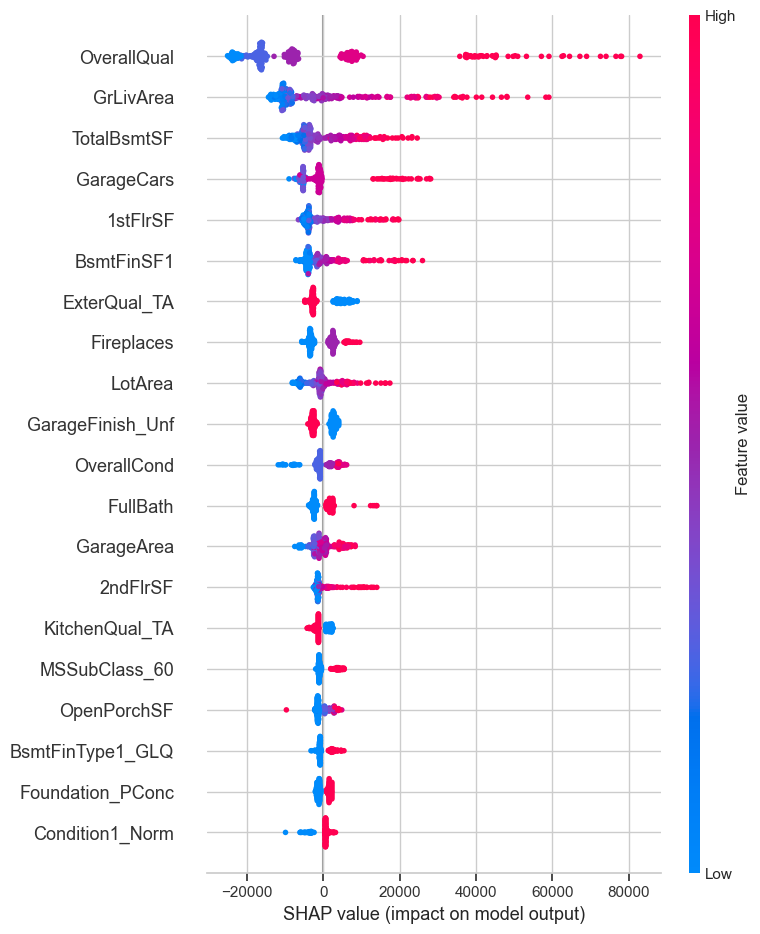

In [74]:
# Feature importance
model = model_lgbm
X =  X_test
                       
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

shap.summary_plot(shap_values, X)
plt.show()

## 6.3. CatBoostRegressor


In [75]:
# Due to CatBoost can handle in a better way categorical columns, we don't need to use the dummies variables we created for the two previous models 
df_pre_models.head(1)

Id MSSubClass MSZoning  LotFrontage  LotArea Street LotShape LandContour  \
0  1         60       RL         65.0     8450   Pave      Reg         Lvl   

  Utilities LotConfig  ... EnclosedPorch 3SsnPorch ScreenPorch PoolArea  \
0    AllPub    Inside  ...             0         0           0        0   

  MiscVal MoSold  YrSold  SaleType SaleCondition SalePrice  
0       0      2    2008        WD        Normal    208500  

[1 rows x 76 columns]

In [76]:
# Checking columns again
print(label)
print(useless)
print(numerical)
print(categorical)

['SalePrice']
['Id']
['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal']
['MSSubClass', 'MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'MoSo

In [77]:
# Getting X and y without dummies
df_catboost = df_pre_models.copy()

df_catboost.drop(useless[0], axis=1, inplace=True)

X = df_catboost[numerical+categorical]
y = df_catboost[label[0]]

print(f'Shape X : {X.shape}')
print(f'Shape y : {y.shape}')

Shape X : (1460, 74)
Shape y : (1460,)


In [78]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f'Shape X_train: {X_train.shape}')
print(f'Shape y_train: {y_train.shape}\n')

print(f'Shape X_test: {X_test.shape}')
print(f'Shape y_test: {y_test.shape}')

Shape X_train: (1168, 74)
Shape y_train: (1168,)

Shape X_test: (292, 74)
Shape y_test: (292,)


In [79]:
cat_features = X.select_dtypes(include='object').columns.to_list()
print(cat_features)

['MSSubClass', 'MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'MoSold', 'YrSold', 'SaleType', 'SaleCondition']


In [80]:
# Hyperparameter Tuning
def optuna_ctb(trial):
  '''Hyperparameter Tuning | Function to find the best combitation of hyperparameters based on a list of them'''
  
  # Normal X_train and y_train
  X, y = X_train, y_train

  # Parameters
  param = {
        'cat_features': cat_features,
        'max_depth': trial.suggest_int('max_depth', 1, 30),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'min_child_samples': trial.suggest_int('min_child_weight', 1, 10),
        #'gamma': trial.suggest_float('gamma', 0.01, 1.0),
        'subsample': trial.suggest_float('subsample', 0.01, 1.0),
        'colsample_bylevel': trial.suggest_float('colsample_bytree', 0.01, 1.0),
        #'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 1.0),
        'random_state': trial.suggest_int('random_state', 1, 1000)
    }
  
  # Model
  
  model = CatBoostRegressor(**param)

  # Score | RMSE by applying cross-validation
  score = np.sqrt(-cross_val_score(estimator = model, X=X, y=y, scoring='neg_mean_squared_error', cv=5)).mean()

  return score

In [81]:
%%time
# Setting the experiment to find the best hyperparameters combination
model_name = 'CatBoost'
optuna_model = optuna_ctb

study_ctb = optuna.create_study(study_name = f'Hyperparameter Optimization | {model_name}',direction = "minimize")
study_ctb.optimize(optuna_model, n_trials = 15)

# Print the best parameters
print('Best parameters', study_ctb.best_params)

# Print the best value
print('\nBest value', study_ctb.best_value)

[I 2022-12-21 14:47:27,238] A new study created in memory with name: Hyperparameter Optimization | CatBoost


0:	learn: 46910.4061887	total: 1.79s	remaining: 29m 34s
1:	learn: 31740.7218081	total: 2.74s	remaining: 22m 39s
2:	learn: 26645.1809933	total: 2.78s	remaining: 15m 16s
3:	learn: 19136.8342934	total: 4.37s	remaining: 18m 1s
4:	learn: 15320.4917303	total: 6.16s	remaining: 20m 17s
5:	learn: 11449.0320357	total: 7.97s	remaining: 21m 51s
6:	learn: 9566.1157679	total: 10.1s	remaining: 23m 37s
7:	learn: 9072.6448573	total: 12.6s	remaining: 25m 48s
8:	learn: 7276.5898581	total: 14.5s	remaining: 26m 29s
9:	learn: 6172.6654797	total: 16.8s	remaining: 27m 29s
10:	learn: 4074.8107564	total: 18.6s	remaining: 27m 42s
11:	learn: 4057.9092560	total: 18.6s	remaining: 25m 23s
12:	learn: 3410.9841839	total: 20.5s	remaining: 25m 44s
13:	learn: 2579.8513626	total: 22.4s	remaining: 26m 7s
14:	learn: 2163.8030666	total: 24.6s	remaining: 26m 46s
15:	learn: 1745.5057569	total: 26.8s	remaining: 27m 15s
16:	learn: 1363.0991941	total: 28.9s	remaining: 27m 37s
17:	learn: 1169.6494177	total: 30.5s	remaining: 27m 32

[I 2022-12-21 16:32:14,679] Trial 0 finished with value: 43831.851727210895 and parameters: {'max_depth': 14, 'learning_rate': 0.5114231036379322, 'n_estimators': 993, 'min_child_weight': 2, 'subsample': 0.6793126367135789, 'colsample_bytree': 0.5454191006096594, 'reg_lambda': 0.09529310126938775, 'random_state': 848}. Best is trial 0 with value: 43831.851727210895.


0:	learn: 43948.7075142	total: 10.6s	remaining: 44m 26s
1:	learn: 31387.2759097	total: 20.6s	remaining: 43m 1s
2:	learn: 23737.1827793	total: 30.4s	remaining: 42m 17s
3:	learn: 17860.2805907	total: 39.2s	remaining: 40m 41s
4:	learn: 13777.7920049	total: 47.5s	remaining: 39m 17s
5:	learn: 11179.9741807	total: 54.5s	remaining: 37m 23s
6:	learn: 9615.1667793	total: 1m 3s	remaining: 36m 58s
7:	learn: 7684.7360490	total: 1m 12s	remaining: 37m 4s
8:	learn: 5837.1537950	total: 1m 22s	remaining: 37m 14s
9:	learn: 4681.4531453	total: 1m 30s	remaining: 36m 32s
10:	learn: 3644.2773294	total: 1m 36s	remaining: 35m 26s
11:	learn: 3195.1564433	total: 1m 38s	remaining: 32m 54s
12:	learn: 2445.8828487	total: 1m 44s	remaining: 32m
13:	learn: 1917.1009893	total: 1m 51s	remaining: 31m 45s
14:	learn: 1502.8604383	total: 1m 58s	remaining: 31m 15s
15:	learn: 1336.4380128	total: 2m 5s	remaining: 31m 1s
16:	learn: 1212.9800594	total: 2m 13s	remaining: 30m 54s
17:	learn: 1005.2512102	total: 2m 21s	remaining: 3

[W 2022-12-21 16:40:10,236] Trial 1 failed because of the following error: KeyboardInterrupt('')
Traceback (most recent call last):
  File "c:\Users\arulloao\Anaconda3\lib\site-packages\optuna\study\_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\arulloao\AppData\Local\Temp\ipykernel_21328\533156703.py", line 28, in optuna_ctb
    score = np.sqrt(-cross_val_score(estimator = model, X=X, y=y, scoring='neg_mean_squared_error', cv=5)).mean()
  File "c:\Users\arulloao\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 509, in cross_val_score
    cv_results = cross_validate(
  File "c:\Users\arulloao\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 267, in cross_validate
    results = parallel(
  File "c:\Users\arulloao\Anaconda3\lib\site-packages\joblib\parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "c:\Users\arulloao\Anaconda3\lib\site-packages\joblib\parallel.p

KeyboardInterrupt: 

In [ ]:
# Plot contour
optuna.visualization.plot_contour(study_ctb)

In [ ]:
# Plot Hyperparameters importances
optuna.visualization.plot_param_importances(study_ctb)

In [ ]:
# Plot optimization history
optuna.visualization.plot_optimization_history(study_ctb)

In [ ]:
# Training the model based on the Hyperparameter Tuning
model_ctb = CatBoostRegressor(  cat_features=cat_features,
                                max_depth = 8, 
                                learning_rate = 0.3403460514083012, 
                                n_estimators = 758, 
                               # min_child_weight = 5, 
                                subsample = 0.8763456969555734, 
                               # colsample_bytree = 0.8410283267319834, 
                                reg_lambda = 0.45261751287455576, 
                                random_state = 309
                            )
model_ctb.fit(X_train, y_train)

y_pred = model_ctb.predict(X_test)

0:	learn: 60085.4888322	total: 86.5ms	remaining: 1m 5s
1:	learn: 47437.6382551	total: 173ms	remaining: 1m 5s
2:	learn: 40798.2647453	total: 263ms	remaining: 1m 6s
3:	learn: 34621.1916695	total: 332ms	remaining: 1m 2s
4:	learn: 30309.6210882	total: 409ms	remaining: 1m 1s
5:	learn: 27329.0725010	total: 515ms	remaining: 1m 4s
6:	learn: 25354.9989627	total: 622ms	remaining: 1m 6s
7:	learn: 23899.5197278	total: 716ms	remaining: 1m 7s
8:	learn: 22203.7058592	total: 867ms	remaining: 1m 12s
9:	learn: 20668.3269901	total: 957ms	remaining: 1m 11s
10:	learn: 19746.6394164	total: 1.09s	remaining: 1m 14s
11:	learn: 18971.0421781	total: 1.18s	remaining: 1m 13s
12:	learn: 18549.4320806	total: 1.28s	remaining: 1m 13s
13:	learn: 18039.7096037	total: 1.38s	remaining: 1m 13s
14:	learn: 17471.3121503	total: 1.47s	remaining: 1m 12s
15:	learn: 17011.3723189	total: 1.56s	remaining: 1m 12s
16:	learn: 16625.7939408	total: 1.65s	remaining: 1m 11s
17:	learn: 16111.1555097	total: 1.76s	remaining: 1m 12s
18:	learn

In [ ]:
# Metrics on the test dataset
metrics_ctb = dict()

expected_y  = y_test.copy()
predicted_y = y_pred.copy()

metrics_ctb['rmse']     = [mean_squared_error(expected_y,predicted_y, squared=False)]
metrics_ctb['r2']       = [r2_score(expected_y,predicted_y)]
metrics_ctb['mae']      = [mean_absolute_error(expected_y, predicted_y)]
metrics_ctb['mse']      = [mean_squared_error(expected_y, predicted_y)]
metrics_ctb['mae_log']  = [mean_squared_log_error(expected_y, predicted_y)]

metrics_ctb = pd.DataFrame(metrics_ctb, columns=metrics_ctb.keys())
metrics_ctb

rmse        r2         mae           mse   mae_log
0  30630.25223  0.877683  17728.6149  9.382124e+08  0.020963

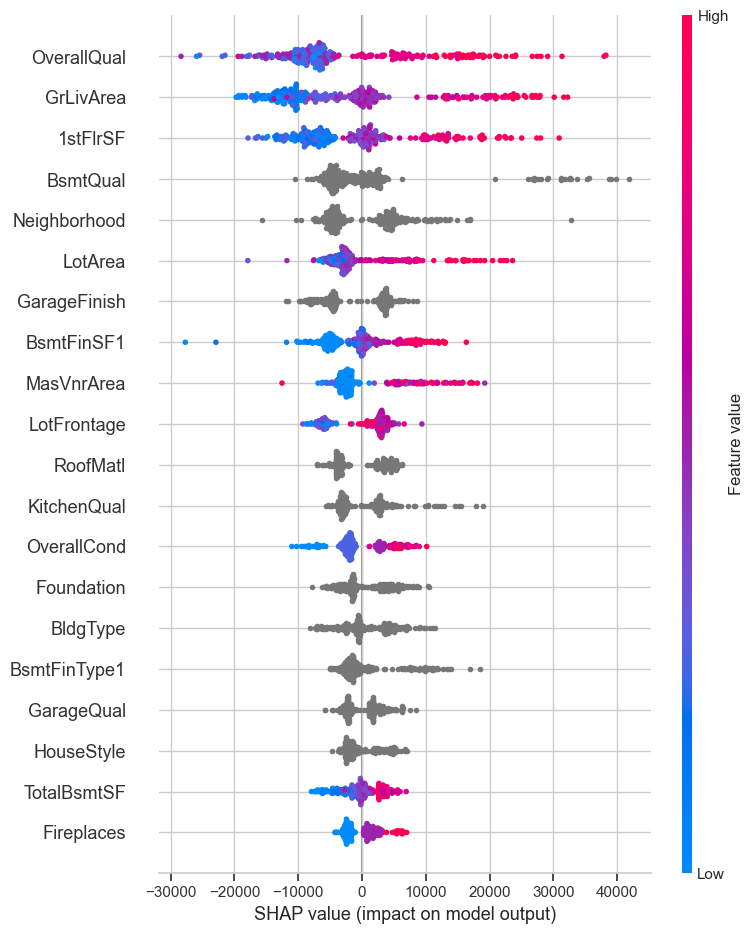

In [ ]:
# Feature importance
model = model_ctb
X =  X_test
                       
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

shap.summary_plot(shap_values, X)
plt.show()

##### Testing normal catboost

In [ ]:
# First try with a catboost regressor

## Data
data_model = data_preprocessed.copy()
data_model.drop('Id', axis=1, inplace=True)

X = data_model.drop('SalePrice', axis=1)
y = data_model['SalePrice']

## Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

train_dataset = Pool(X_train, y_train, cat_features = cat_features) 
test_dataset = Pool(X_test, y_test, cat_features=cat_features)

## Set model
cat_features = X.select_dtypes(include='object').columns.to_list()

model_CBR_1 = CatBoostRegressor(cat_features = cat_features, loss_function= 'RMSE')

## Training 
model_CBR_1.fit(train_dataset)

Learning rate set to 0.041084
0:	learn: 75540.1868138	total: 50.7ms	remaining: 50.7s
1:	learn: 73647.0185157	total: 106ms	remaining: 52.7s
2:	learn: 72001.3210450	total: 163ms	remaining: 54.3s
3:	learn: 70206.4812538	total: 240ms	remaining: 59.8s
4:	learn: 68628.9648241	total: 291ms	remaining: 58s
5:	learn: 67019.0892551	total: 333ms	remaining: 55.2s
6:	learn: 65559.9776390	total: 385ms	remaining: 54.6s
7:	learn: 64076.8552578	total: 435ms	remaining: 53.9s
8:	learn: 62617.2652129	total: 484ms	remaining: 53.3s
9:	learn: 61199.2860490	total: 539ms	remaining: 53.3s
10:	learn: 59745.1423166	total: 587ms	remaining: 52.8s
11:	learn: 58395.4315793	total: 639ms	remaining: 52.6s
12:	learn: 57274.6778111	total: 701ms	remaining: 53.3s
13:	learn: 56175.7312383	total: 753ms	remaining: 53.1s
14:	learn: 55017.2526300	total: 807ms	remaining: 53s
15:	learn: 53985.1706237	total: 858ms	remaining: 52.7s
16:	learn: 52998.3558822	total: 910ms	remaining: 52.6s
17:	learn: 51887.2667871	total: 956ms	remaining:

In [ ]:
print(model_CBR_1.get_all_params())

{'nan_mode': 'Min', 'eval_metric': 'RMSE', 'combinations_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1', 'Counter:CtrBorderCount=15:CtrBorderType=Uniform:Prior=0/1'], 'iterations': 1000, 'sampling_frequency': 'PerTree', 'fold_permutation_block': 0, 'leaf_estimation_method': 'Newton', 'counter_calc_method': 'SkipTest', 'grow_policy': 'SymmetricTree', 'penalties_coefficient': 1, 'boosting_type': 'Plain', 'model_shrink_mode': 'Constant', 'feature_border_type': 'GreedyLogSum', 'ctr_leaf_count_limit': 18446744073709551615, 'bayesian_matrix_reg': 0.10000000149011612, 'one_hot_max_size': 2, 'eval_fraction': 0, 'force_unit_auto_pair_weights': False, 'l2_leaf_reg': 3, 'random_strength': 1, 'rsm': 1, 'boost_from_average': True, 'max_ctr_complexity': 4, 'model_size_reg': 0.5, 'simple_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:

In [ ]:
# 'cat_features': cat_features,
# 'max_depth': trial.suggest_int('max_depth', 1, 30),
# 'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
# 'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
# 'min_child_samples': trial.suggest_int('min_child_weight', 1, 10),
# #'gamma': trial.suggest_float('gamma', 0.01, 1.0),
# 'subsample': trial.suggest_float('subsample', 0.01, 1.0),
# 'colsample_bylevel': trial.suggest_float('colsample_bytree', 0.01, 1.0),
# #'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 1.0),
# 'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 1.0),
# 'random_state': trial.suggest_int('random_state', 1, 1000)

In [ ]:
# Metrics on the test dataset
model_ctb_normal = dict()

expected_y  = y_test
predicted_y = pd.Series(model_CBR_1.predict(test_dataset))

model_ctb_normal['rmse']     = [mean_squared_error(expected_y,predicted_y, squared=False)]
model_ctb_normal['r2']       = [r2_score(expected_y,predicted_y)]
model_ctb_normal['mae']      = [mean_absolute_error(expected_y, predicted_y)]
model_ctb_normal['mse']      = [mean_squared_error(expected_y, predicted_y)]
model_ctb_normal['mae_log']  = [mean_squared_log_error(expected_y, predicted_y)]

model_ctb_normal = pd.DataFrame(model_ctb_normal, columns=model_ctb_normal.keys())
model_ctb_normal

rmse        r2           mae           mse   mae_log
0  23749.788256  0.919168  14787.361901  5.640524e+08  0.015253

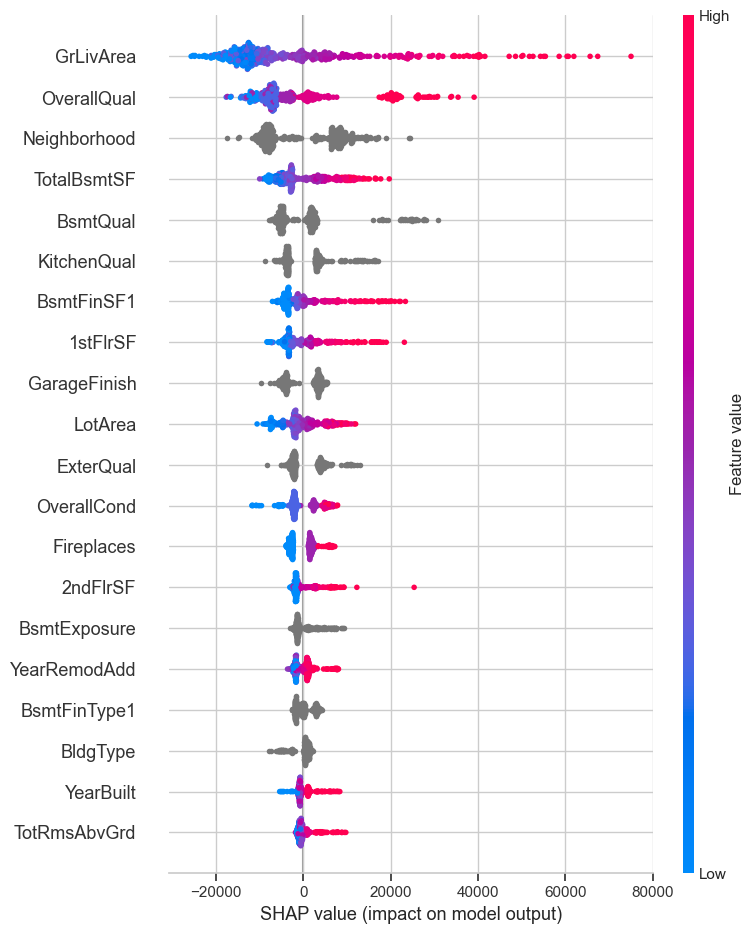

In [ ]:
# Feature importance
model = model_CBR_1
X =  X_test
                       
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

shap.summary_plot(shap_values, X)
plt.show()

In [309]:
# Best marca so far
pd.DataFrame(metricas, columns=metricas.keys())

rmse        r2           mae           mse   mae_log
0  23544.581085  0.920559  14704.852188  5.543473e+08  0.015307

## 7. Results

##### TODO

- Dejar la variable de garages tal cual
- Iterar sobre los 3 modelos
- Elegir el mejor
- Pequeña descripcion de pq elegimos ese modelo
- Predecir el set de validacion
- Ordenar y revisar notebook
- Enviar resultados Kaggle
- Informe
- Enviar tarea